In [ ]:
# This is for analyzing layer data 

import os
import numpy as np
import scipy
from scipy.linalg import orthogonal_procrustes
import matplotlib.pyplot as plt
import nibabel as nib
import pyvista as pv
import yaspy
from brainspace.gradient import GradientMaps
from brainspace.gradient.kernels import compute_affinity
import brainspace.gradient.alignment as ga
from brainspace.utils.parcellation import map_to_labels

#pv.start_xvfb()
radius = 6
add_bigbrain_data = True
do_parcellation = True#should be TRUE most of the time
baseDir = '/Users/dennis.jungchildmind.org/Downloads/exvivo/'
baseDir_bigbrain = '/Users/dennis.jungchildmind.org/Downloads/BigBrain/thickness/resample/'
#for hcp
#baseDir = '/Users/dennis.jungchildmind.org/OneDrive - Child Mind Institute/hcp1200/HCP1200/'
# Get all subdirectories in baseDir

#schaefer400
#it is important to use the same schaefer atlas used for the gradient analysis
atlas_path = '/Users/dennis.jungchildmind.org/OneDrive - Child Mind Institute/parcellation/schaefer2018/Schaefer2018_400Parcels_7Networks_order.dlabel.nii'
atlas = nib.load(atlas_path).get_fdata()[0].astype(int)
#split atlas into left and right hemispheres for later use       
atlas_data_lh = atlas[:len(atlas)//2]
atlas_data_rh = atlas[len(atlas)//2:]
atlas_data_rh = atlas_data_rh - np.min(atlas_data_rh[atlas_data_rh != 0])+1
atlas_data_rh[atlas_data_rh <= 0] = 0
num_parcels = int(atlas_path.split('_')[1].split('Parcels')[0])  # Extract number of parcels from atlas path
#get Yeo Networks from the label data
yeo_networks = nib.load(atlas_path).header.get_axis(0)
yeo_network_data = yeo_networks.get_element(0)[1]

#each yeo_network_data[key] has ('17Networks_LH_VisCent_ExStr_1',...), save the third string after string split by '_'
yeo_network_names = []
yeo_network_colors = []
for i,key in enumerate(yeo_network_data):
    if i == 0:
        yeo_network_names.append(np.nan)
        yeo_network_colors.append((0,0,0,0))
        continue#skip the first key
   # print(yeo_network_data[key][0])#network name
    network_parts = yeo_network_data[key][0].split('_')
    #print(network_parts)
    yeo_network_names.append(network_parts[2])  # Append the network name (VisCent)
    yeo_network_colors.append(yeo_network_data[key][1])


#get all subject directories in the baseDir
subject_dirs = [d for d in os.listdir(baseDir) if os.path.isdir(os.path.join(baseDir, d))]
# Find index of item containing 'L54' that has both hemipshere, we just want to put the subject with both hemispehres at the beginning of the list
# and if the BigBrain data is added, we want to put at the end of the list (later)
l54_idx = next(i for i, s in enumerate(subject_dirs) if 'I54' in s)
print(f"Index of L54: {l54_idx}")
#move the item at index l54_idx to the beggining of the list
subject_dirs.insert(0, subject_dirs.pop(l54_idx))



pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Index of L54: 6


In [14]:
'''
#testing difference between 17 and 7 networks (I was informed that they are supposed to be different! I still don't konw the exact reason why)
atlas_y17_path = '/Users/dennis.jungchildmind.org/OneDrive - Child Mind Institute/parcellation/schaefer2018/Schaefer2018_400Parcels_17Networks_order.dlabel.nii'
atlas_y17 = nib.load(atlas_y17_path).get_fdata()[0].astype(int)
atlas_y7_path = '/Users/dennis.jungchildmind.org/OneDrive - Child Mind Institute/parcellation/schaefer2018/Schaefer2018_400Parcels_7Networks_order.dlabel.nii'
atlas_y7 = nib.load(atlas_y7_path).get_fdata()[0].astype(int)

plt.figure(figsize=(6, 6))
plt.plot(atlas_y7,atlas_y17,'.')
plt.xlim(-1,400)
plt.ylim(-1,400)
plt.show()

plt.figure(figsize=(12,4))
plt.plot(atlas_y7, label='Yeo 7 Networks', linewidth=0.5, alpha=0.7)
plt.plot(atlas_y17, label='Yeo 17 Networks', linewidth=0.5, alpha=0.7)
plt.xlabel('Vertex Index')
plt.ylabel('Schaefer 400 Parcel Number')
plt.title('Atlas Parcellation Comparison')
plt.legend()
plt.show()
'''

"\n#testing difference between 17 and 7 networks (I was informed that they are supposed to be different! I still don't konw the exact reason why)\natlas_y17_path = '/Users/dennis.jungchildmind.org/OneDrive - Child Mind Institute/parcellation/schaefer2018/Schaefer2018_400Parcels_17Networks_order.dlabel.nii'\natlas_y17 = nib.load(atlas_y17_path).get_fdata()[0].astype(int)\natlas_y7_path = '/Users/dennis.jungchildmind.org/OneDrive - Child Mind Institute/parcellation/schaefer2018/Schaefer2018_400Parcels_7Networks_order.dlabel.nii'\natlas_y7 = nib.load(atlas_y7_path).get_fdata()[0].astype(int)\n\nplt.figure(figsize=(6, 6))\nplt.plot(atlas_y7,atlas_y17,'.')\nplt.xlim(-1,400)\nplt.ylim(-1,400)\nplt.show()\n\nplt.figure(figsize=(12,4))\nplt.plot(atlas_y7, label='Yeo 7 Networks', linewidth=0.5, alpha=0.7)\nplt.plot(atlas_y17, label='Yeo 17 Networks', linewidth=0.5, alpha=0.7)\nplt.xlabel('Vertex Index')\nplt.ylabel('Schaefer 400 Parcel Number')\nplt.title('Atlas Parcellation Comparison')\nplt.l

In [15]:
#parcellation of the data based on the given atlas (atlas_data).
def parcellate_data(data,atlas_data):
    """
    data: numpy array
    atlas_data: numpy array
    hemisphere: string
    """

    #parcellate data
    len_unique = len(np.unique(atlas_data[atlas_data != 0]))
    data_parc = np.zeros((len_unique))
  
    for i in range(len_unique):
        parcel_data = data[atlas_data == i+1]
        # First remove NaN values
        parcel_data = parcel_data[~np.isnan(parcel_data)]
        if len(parcel_data) == 0:
            data_parc[i] = 0
            continue
        # Calculate mean and std of non-NaN values
        parcel_data_mean = np.mean(parcel_data)
        parcel_data_std = np.std(parcel_data)
        # Keep only values within 2 std of mean
        mask = np.abs(parcel_data - parcel_data_mean) < (2 * parcel_data_std)
        filtered_data = parcel_data[mask]
        # Calculate final mean of filtered data
        if len(filtered_data) > 0:
            data_parc[i] = np.mean(filtered_data)
        else:
            print(data[atlas_data == i+1])
            print('no data',i)
            data_parc[i] = 0
    return data_parc


# Function to create eigenvalue plot
def plot_eigenvalues(gm_aligned, color='#2E86C1', filename=None, save=False, SAVEFOLDER='./figures/eigenvalues'):
    # Create figure and axis
    fig, ax = plt.subplots(figsize=(4, 4))   
    
    # Calculate and plot normalized eigenvalues 
    eigenvalues = gm_aligned[0].lambdas_ / np.sum(gm_aligned[0].lambdas_)
    ax.plot(range(1, len(eigenvalues) + 1), eigenvalues, 'o-', 
            color=color, linewidth=2, markersize=6)
    
    # Customize plot
    ax.set_xlabel('Component', fontsize=18)
    ax.set_ylabel('Variance explained', fontsize=18)
    ax.grid(True, linestyle='--', alpha=0.7)
    ax.set_xlim(0, len(eigenvalues))
    ax.yaxis.set_major_formatter(plt.FormatStrFormatter('%.2f'))
    ax.tick_params(axis='both', which='major', labelsize=20)
    
    plt.tight_layout()
    
    if save:
        # Make folder if it doesn't exist
        if not os.path.exists(SAVEFOLDER):
            os.makedirs(SAVEFOLDER)
        plt.savefig(os.path.join(SAVEFOLDER, f'{filename}_eigenvalues.png'), dpi=300)
        plt.close()
        return
    
    return fig, ax


In [16]:


def plot_correlation_matrix(corr, transpose, title, vmin,vmax,cmap):
    """Plot correlation matrix with consistent formatting."""
    # Remove diagonal values
    corr_plot = corr.copy()
    corr_plot[np.eye(corr_plot.shape[0], dtype=bool)] = np.nan
    
    # Plot matrix
    im = plt.imshow(corr_plot, cmap=cmap, vmin=vmin, vmax=vmax)
        
    plt.colorbar(im, fraction=0.046, pad=0.04)
    plt.title(f'{title}',fontsize=16,fontweight='bold')
    if transpose:
        plt.xlabel('Subject',fontsize=16)
        plt.ylabel('Subject',fontsize=16)
    else:
        plt.xlabel('Parcel',fontsize=16)
        plt.ylabel('Parcel',fontsize=16)
    
    return corr

def plot_subject_similarity(hemisphere_data, transpose=False, vmin = 0, vmax = 1, cmap='viridis',partial_corr=False):
    """
    Plot similarity matrices between subjects for different thickness measures and radii.
    
    Args:
        hemisphere_data (dict): Dictionary containing thickness data for one hemisphere
        radii (list): List of radius values used for smoothing
        transpose (bool): Whether to transpose the data matrices
        partial_corr (bool): Whether to calculate partial correlations
        shrink_it (bool): Whether to apply shrinkage to correlation calculation
    """
    # Initialize correlation dictionaries
    correlation_dicts = {
        'total': {},
        'infra': {},
        'supra': {},
        'relative': {},
        'ratio_supra': {},
        'ratio_infra': {}
    }

    first_index = 0
    plt.figure(figsize=(len(correlation_dicts)*4,4))

    # Define measures and their plot positions
    measures = [
        ('total', 'Total Thickness', 1),
        ('infra', 'Infra Thickness', 2), 
        ('supra', 'Supra Thickness', 3),
        ('relative', 'Relative (Supra/Infra)', 4),
        ('ratio_supra', 'Ratio (Supra/Total)', 5),
        ('ratio_infra', 'Ratio (Infra/Total)', 6)
    ]
    
    # Plot each measure
    for measure, title, plot_pos in measures:
        plt.subplot(1, len(measures), plot_pos)
        data = hemisphere_data[measure]
        if transpose:
            data = data[first_index:].T
        else:
            data = data[first_index:]

        # Yes, np.corrcoef calculates Pearson correlation coefficients
        corr = np.corrcoef(data)

        # Store and plot correlation matrix
        correlation_dicts[measure][0] = plot_correlation_matrix(
            corr,
            transpose,
            title,
            vmin,
            vmax,
            cmap
        )

    plt.tight_layout()
    
    return tuple(correlation_dicts[k] for k in ['total', 'infra', 'supra', 'relative', 'ratio_supra', 'ratio_infra'])


In [17]:
data_types = ['infra', 'supra', 'relative', 'ratio_supra', 'ratio_infra', 'total','diff']
hemispheres = {'lh': 'left', 'rh': 'right'}

# Initialize data dictionary with nested structure for hemispheres and data types
data = {hemi: {dtype: [] for dtype in data_types} for hemi in hemispheres}

def clean_data(data_array):
    """Clean NaN and Inf values from array"""
    # Use numpy's masked array to handle invalid values more robustly
    masked_array = np.ma.masked_invalid(data_array)
    cleaned_array = np.array(masked_array.filled(0))
    return cleaned_array

def load_thickness_exvivo_data(base_dir, subject_dir, hemi, suffix):
    """Load thickness measurements for a given subject and hemisphere"""
    return {
        'infra': nib.load(f'{base_dir}{subject_dir}/{hemi}.thickness.wm.inf.{suffix}.shape.gii').darrays[0].data,
        'supra': nib.load(f'{base_dir}{subject_dir}/{hemi}.thickness.inf.pial.{suffix}.shape.gii').darrays[0].data,
        'total': nib.load(f'{base_dir}{subject_dir}/{hemi}.thickness.{suffix}.shape.gii').darrays[0].data
        #this code below is to load data already parcellated
        #'infra': nib.load(f'{base_dir}{subject_dir}/{hemi}.thickness.wm.inf.{suffix}.Schaefer2018_400Parcels.pscalar.nii').get_fdata()[0],
        #'supra': nib.load(f'{base_dir}{subject_dir}/{hemi}.thickness.inf.pial.{suffix}.Schaefer2018_400Parcels.pscalar.nii').get_fdata()[0],
        # 'total': nib.load(f'{base_dir}{subject_dir}/{hemi}.thickness.{suffix}.Schaefer2018_400Parcels.pscalar.nii').get_fdata()[0]
    }

def load_thickness_bigbrain_data(base_dir, hemi):
    """Load thickness measurements for a given subject and hemisphere"""
    return {
        'infra': nib.load(f'{base_dir}/{hemi}.3-6.32k.shape.gii').darrays[0].data,#layers 4,5,6 (ex vivo style)
        'supra': nib.load(f'{base_dir}/{hemi}.0-3.32k.shape.gii').darrays[0].data,#layers 1,2,3
        'total': nib.load(f'{base_dir}/{hemi}.0-6.32k.shape.gii').darrays[0].data#all layers
        #this code below is to load data already parcellated
        #'infra': nib.load(f'{base_dir}/{hemi}.3-6.32k._6mm_fwhm.Schaefer2018_400Parcels.pscalar.nii').get_fdata()[0],#layers 4,5,6 (ex vivo style)
        #'supra': nib.load(f'{base_dir}/{hemi}.0-3.32k._6mm_fwhm.Schaefer2018_400Parcels.pscalar.nii').get_fdata()[0],#layers 1,2,3
        #'total': nib.load(f'{base_dir}/{hemi}.0-6.32k._6mm_fwhm.Schaefer2018_400Parcels.pscalar.nii').get_fdata()[0]#all layers
    }

def calculate_derived_measurements(thickness_data):
    """Calculate derived thickness measurements"""
    return {
        'relative': clean_data(np.divide(thickness_data['supra'], thickness_data['infra'], out=np.zeros_like(thickness_data['supra']), where=thickness_data['infra']!=0)),
        'ratio_supra': clean_data(np.divide(thickness_data['supra'], thickness_data['total'], out=np.zeros_like(thickness_data['supra']), where=thickness_data['total']!=0)),
        'ratio_infra': clean_data(np.divide(thickness_data['infra'], thickness_data['total'], out=np.zeros_like(thickness_data['infra']), where=thickness_data['total']!=0)),
        'diff': clean_data((thickness_data['infra'] - thickness_data['supra'])/(thickness_data['infra'] + thickness_data['supra']))
    }

#save list of subjects of lh and rh separately
lh_subjects = []
rh_subjects = []
lh_subjects_name = []
rh_subjects_name = []


#run the code to load data
for subjectDir in subject_dirs:
    for hemi in hemispheres:
        surf_file = f'{baseDir}{subjectDir}/{hemi}.pial.32k_fs_LR.surf.gii'
        if os.path.exists(surf_file):
            if hemi == 'lh':
                lh_subjects.append(subjectDir)
                lh_subjects_name.append(subjectDir.replace('_new_confidence', ''))
            else:
                rh_subjects.append(subjectDir)
                rh_subjects_name.append(subjectDir.replace('_new_confidence', ''))
            #suffix = '32k_fs_LR'
            suffix = '32k_6mm_fwhm_fs_LR'
            #suffix = f'32k_{radius}mm_fwhm_fs_LR'
            # Load and process thickness data
            thickness_data = load_thickness_exvivo_data(baseDir, subjectDir, hemi, suffix)
            thickness_data.update(calculate_derived_measurements(thickness_data))
            
            # Store data for each type more efficiently using numpy operations
            for dtype in data_types:
                reshaped = thickness_data[dtype].reshape(-1, 1)
                data[hemi][dtype] = np.concatenate((data[hemi][dtype], reshaped), axis=1) if len(data[hemi][dtype]) > 0 else reshaped

#and then, add the bigbrain data

if add_bigbrain_data:
    for hemi in hemispheres:
        thickness_data = load_thickness_bigbrain_data(baseDir_bigbrain, hemi)
        thickness_data.update(calculate_derived_measurements(thickness_data))
        for dtype in data_types:
            reshaped = thickness_data[dtype].reshape(-1, 1)
            data[hemi][dtype] = np.concatenate((data[hemi][dtype], reshaped), axis=1) if len(data[hemi][dtype]) > 0 else reshaped
    lh_subjects_name.append('bigbrain')
    rh_subjects_name.append('bigbrain')



if do_parcellation:
    #parcellate the data
    for hemi in hemispheres:
        #choose the atlas_data (left or right hemisphere) for parcellation 
        atlas_data = atlas_data_lh if hemi == 'lh' else atlas_data_rh
        #run for each layer type
        for dtype in data_types:
            #run for each file in column
            print('hemi', hemi, 'dtype', dtype)
            tmp_data = []
            for i in range(data[hemi][dtype].shape[1]):
                print('i', i)
                parcellated = parcellate_data(data[hemi][dtype][:,i], atlas_data)
                tmp_data.append(parcellated)
            data[hemi][dtype] = np.array(tmp_data).T



# Rename variables to match rest of code
lh_data_parc = data['lh']
rh_data_parc = data['rh']


#plot the data

/var/folders/71/4g31r9017kq32wt_mx1khjdm0000gn/T/ipykernel_44676/3628789264.py:44: RuntimeWarning: invalid value encountered in divide
  'diff': clean_data((thickness_data['infra'] - thickness_data['supra'])/(thickness_data['infra'] + thickness_data['supra']))


hemi lh dtype infra
i 0
i 1
i 2
i 3
i 4
i 5
i 6
i 7
i 8
i 9
i 10
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0.]
no data 6
i 11
hemi lh dtype supra
i 0
i 1
i 2
i 3
i 4
i 5
i 6
i 7
i 8
i 9
i 10
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0.]
no data 6
i 11
hemi lh dtype relative
i 0
i 1
i 2
i 3
i 4
i 5
i 6
i 7
i 8
i 9
i 10
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0.]
no data 6
i 11
hemi lh dtype ratio_supra
i 0
i

In [18]:
import pickle

# Calculate correlation coefficient w.r.t bigbrain
thickness_corr_wrt_bigbrain = {}
for layer in ['supra', 'infra']:
    for hemi in ['lh', 'rh']:
        if hemi not in thickness_corr_wrt_bigbrain:
            thickness_corr_wrt_bigbrain[hemi] = {}
        corr_matrix = np.corrcoef(data[hemi][layer].T)
        print(corr_matrix.shape)
        thickness_corr_wrt_bigbrain[hemi][layer] = corr_matrix[-1, :]
        print(corr_matrix.shape)



#save the data with subject names
subject_names = {}
subject_names['lh'] = lh_subjects_name
subject_names['rh'] = rh_subjects_name

#save both subject names and thickness_corr_wrt_bigbrain
with open('thickness_corr_wrt_bigbrain_32k.pkl', 'wb') as f:
    pickle.dump({'subject_names': subject_names, 'thickness_corr_wrt_bigbrain': thickness_corr_wrt_bigbrain}, f)


(12, 12)
(12, 12)
(8, 8)
(8, 8)
(12, 12)
(12, 12)
(8, 8)
(8, 8)


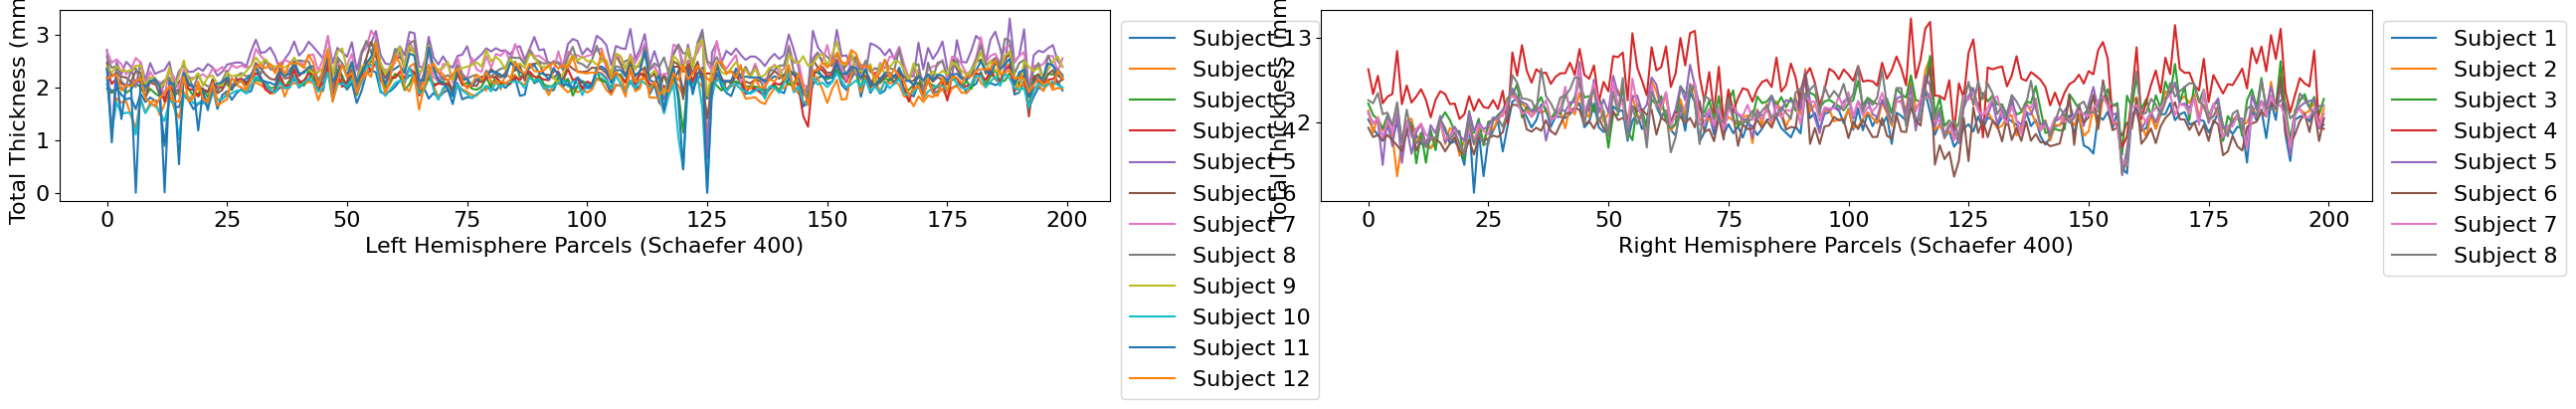

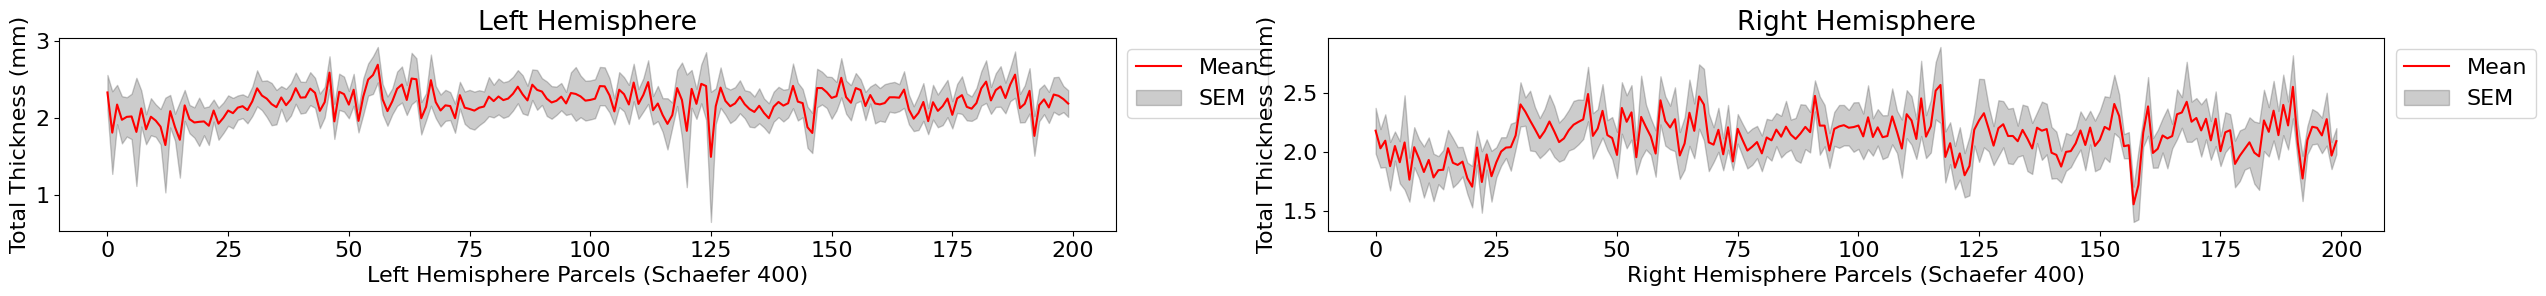

In [19]:
plt.figure(figsize=(30,2.5))
plt.subplot(1,2,1)
plt.plot(data['lh']['total'])
plt.xlabel('Left Hemisphere Parcels (Schaefer 400)')
plt.ylabel('Total Thickness (mm)')
plt.legend(['Subject ' + str(i+1) for i in range(data['lh']['total'].shape[1])], bbox_to_anchor=(1, 1), loc='upper left')

plt.subplot(1,2,2)
plt.plot(data['rh']['total'])
plt.xlabel('Right Hemisphere Parcels (Schaefer 400)')
plt.ylabel('Total Thickness (mm)')
plt.legend(['Subject ' + str(i+1) for i in range(data['rh']['total'].shape[1])], bbox_to_anchor=(1, 1), loc='upper left')

plt.show()

#now plot with mean and sem
plt.figure(figsize=(30,2.5))  
plt.subplot(1,2,1)
plt.plot(np.mean(data['lh']['total'], axis=1), 'r')
plt.fill_between(range(data['lh']['total'].shape[0]), np.mean(data['lh']['total'], axis=1) - np.std(data['lh']['total'], axis=1), np.mean(data['lh']['total'], axis=1) + np.std(data['lh']['total'], axis=1), alpha=0.2, color='k')
plt.xlabel('Left Hemisphere Parcels (Schaefer 400)')
plt.ylabel('Total Thickness (mm)')
plt.legend(['Mean', 'SEM'], bbox_to_anchor=(1, 1), loc='upper left')
plt.title('Left Hemisphere')

plt.subplot(1,2,2)
plt.plot(np.mean(data['rh']['total'], axis=1), 'r')
plt.fill_between(range(data['rh']['total'].shape[0]), np.mean(data['rh']['total'], axis=1) - np.std(data['rh']['total'], axis=1), np.mean(data['rh']['total'], axis=1) + np.std(data['rh']['total'], axis=1), alpha=0.2, color='k')
plt.xlabel('Right Hemisphere Parcels (Schaefer 400)')
plt.ylabel('Total Thickness (mm)')
plt.legend(['Mean', 'SEM'], bbox_to_anchor=(1, 1), loc='upper left')
plt.title('Right Hemisphere')
plt.show()
            

In [20]:


def process_hemisphere_parcellation(lh_data_parc=None, rh_data_parc=None, atlas=None):
    """
    Process left and right hemisphere parcellation data using an atlas
    
    Parameters:
    -----------
    lh_data_parc : dict
        Left hemisphere parcellation data
    rh_data_parc : dict 
        Right hemisphere parcellation data
    atlas : array-like
        Atlas data for mapping
        
    Returns:
    --------
    tuple : Processed left and right hemisphere data
    """
    if lh_data_parc is not None:
        # Process left hemisphere data
        for key in lh_data_parc.keys():
            mask_lh = atlas[:32492] != 0
            min_atlas = np.min(atlas[:32492][atlas[:32492] != 0])
            max_atlas = np.max(atlas[:32492][atlas[:32492] != 0])
            lh_data_parc[key] = map_to_labels(lh_data_parc[key].ravel()[1:], atlas[:32492], 
                                            mask=mask_lh, fill=np.nan,
                                            source_lab=np.arange(min_atlas, max_atlas+1))
 
    if rh_data_parc is not None:
    # Process right hemisphere data 
        for key in rh_data_parc.keys():
            mask_rh = atlas[32492:] != 0
            min_atlas = np.min(atlas[32492:][atlas[32492:] != 0])
            max_atlas = np.max(atlas[32492:][atlas[32492:] != 0])
            rh_data_parc[key] = map_to_labels(rh_data_parc[key].ravel()[1:], atlas[32492:],
                                            mask=mask_rh, fill=np.nan,
                                            source_lab=np.arange(min_atlas, max_atlas+1))
        
    

    return lh_data_parc, rh_data_parc





def combine_hemispheres_data(lh_data_parc, rh_data_parc):
    """
    Combine left and right hemisphere data into grouped dictionaries and fill NaN values with means
    
    Parameters:
    -----------
    lh_data_parc : dict
        Left hemisphere parcellation data
    rh_data_parc : dict
        Right hemisphere parcellation data
        
    Returns:
    --------
    tuple : Three dictionaries containing grouped layer data:
            - layer_group_parc: Combined supra/gra/infra/total thickness data
            - layer_ind_parc: Individual layer (L1-L6) thickness data  
            - layer_extra_parc: Relative and ratio thickness metrics
    """
    # Combine hemisphere data into groups
    layer_group_parc = {
        'supra': {'lh': lh_data_parc['supra'], 'rh': rh_data_parc['supra']},
        'infra': {'lh': lh_data_parc['infra'], 'rh': rh_data_parc['infra']},
        'total': {'lh': lh_data_parc['total'], 'rh': rh_data_parc['total']},
    }

    layer_extra_parc = {
        'relative': {'lh': lh_data_parc['relative'], 'rh': rh_data_parc['relative']},
        'ratio_supra': {'lh': lh_data_parc['ratio_supra'], 'rh': rh_data_parc['ratio_supra']},
        'ratio_infra': {'lh': lh_data_parc['ratio_infra'], 'rh': rh_data_parc['ratio_infra']},
        'diff': {'lh': lh_data_parc['diff'], 'rh': rh_data_parc['diff']},
    }

    # Fill NaN values with means
    for key in layer_group_parc.keys():
        for hemi in ['lh', 'rh']:
            layer_group_parc[key][hemi][np.isnan(layer_group_parc[key][hemi])] = np.mean(layer_group_parc[key][hemi][~np.isnan(layer_group_parc[key][hemi])])

    for key in layer_extra_parc.keys():
        for hemi in ['lh', 'rh']:
            layer_extra_parc[key][hemi][np.isnan(layer_extra_parc[key][hemi])] = np.mean(layer_extra_parc[key][hemi][~np.isnan(layer_extra_parc[key][hemi])])

    return layer_group_parc, layer_extra_parc

(200,)
1 200
atlas_data 32492
(200,)
1 200
atlas_data 32492


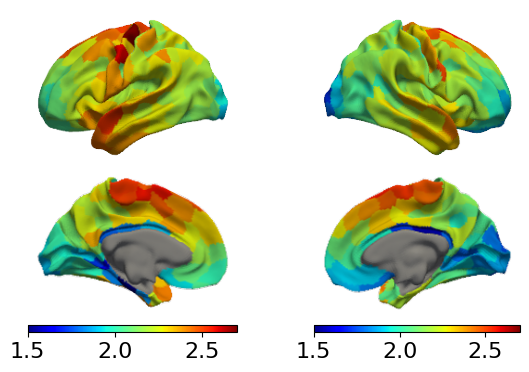

In [21]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
#layer type
layer_type = 'total'  #'predicted_x4'#, 'infra', 'supra', 'relative'

lh_surf = '/Users/dennis.jungchildmind.org/Downloads/HCP_S1200_Atlas_Z4_pkXDZ/S1200.L.white_MSMAll.32k_fs_LR.surf.gii'
rh_surf = '/Users/dennis.jungchildmind.org/Downloads/HCP_S1200_Atlas_Z4_pkXDZ/S1200.R.white_MSMAll.32k_fs_LR.surf.gii'

def mapping_to_atlas(data_parc, atlas_data):
    mapped_values = np.zeros(len(atlas_data))
    print('atlas_data', len(atlas_data))
    for i in range(len(atlas_data)):
        atlas_val = atlas_data[i] #this just gets the parcel index of the atlas (1...400 for Schaefer 400 atlas)
        if atlas_val != 0:
            mapped_values[i] = data_parc[atlas_val-1] 
        else:
            mapped_values[i] = np.nan
    
    return mapped_values
    
def process_hemisphere(data_parc, atlas_data, surf_path, layer_type, hemi,  vmin=None, vmax=None):
    plotters_mean = []
    plotters_var = []
    
    # Calculate overall stats
    means = [np.nanmean(data_parc[layer_type], axis=1)][0]
    print(means.shape)
  
    #
    min_atlas = np.nanmin(atlas_data[atlas_data != 0])
    max_atlas = np.nanmax(atlas_data[atlas_data != 0])
    print(min_atlas, max_atlas)

    mean_surfaces = mapping_to_atlas(means, atlas_data)

        
    # Set visualization parameters based on layer type
    if layer_type == 'relative':
        vmin_mean = 0.8
        vmax_mean = 1.2
        cmap = 'RdBu_r'

    elif 'ratio' in layer_type:
        vmin_mean = 0.4
        vmax_mean = 0.6
        cmap = 'RdBu_r'
    
    else:
        vmin_mean = np.round(np.nanmin(mean_surfaces), decimals=2) if vmin is None else vmin
        vmax_mean = np.round(np.nanmax(mean_surfaces), decimals=2) if vmax is None else vmax
        cmap = 'jet'


    # Generate plots
    plotter_mean = yaspy.Plotter(surf_path, hemi=hemi)
    overlay_mean = plotter_mean.overlay(mean_surfaces, cmap=cmap, alpha=1, 
                                     vmin=vmin_mean, vmax=vmax_mean)
    plotter_mean.border(mean_surfaces, alpha=0)
    plotters_mean.append([plotter_mean.screenshot("lateral"), 
                        plotter_mean.screenshot("medial"), 
                        overlay_mean])

                       
    return plotters_mean, vmin_mean, vmax_mean


plotters_lh_mean, vmin_lh, vmax_lh = process_hemisphere(lh_data_parc, atlas_data_lh, lh_surf, layer_type, 'lh')
plotters_rh_mean, vmin_rh, vmax_rh = process_hemisphere(rh_data_parc, atlas_data_rh, rh_surf, layer_type,'rh',vmin=vmin_lh, vmax=vmax_lh)

# Create montages
def create_montage(plotters):
    return yaspy.montage([[p[0] for p in plotters], [p[1] for p in plotters]], 
                        pad=10, shareh=True, sharew=True)

img_lh_mean = create_montage(plotters_lh_mean)
img_rh_mean = create_montage(plotters_rh_mean) 


# Plot results
def plot_hemispheres(img_lh, img_rh, plotters_lh, plotters_rh,vmin=None, vmax=None):
    f, (ax1, ax2) = plt.subplots(1,2,figsize=(6,4))
    
    ax1.imshow(img_lh)      
    ax1.axis('off')
    
    ax2.imshow(img_rh)
    ax2.axis('off')
    
    # Add colorbars with same normalization
    norm = plt.Normalize(vmin=vmin, vmax=vmax)
    for ax, plotters in [(ax1, plotters_lh), (ax2, plotters_rh)]:
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("bottom", size="2.5%", pad=0.05)
        sm = plt.cm.ScalarMappable(norm=norm, cmap=plotters[0][2].get_cmap())
        #sm.set_clim(vmin=np.round(vmin, decimals=0), vmax=np.round(vmax, decimals=0))
        plt.colorbar(sm, cax=cax, orientation="horizontal")
    
    plt.tight_layout()
    plt.show()

plot_hemispheres(img_lh_mean, img_rh_mean, plotters_lh_mean, plotters_rh_mean,vmin=vmin_lh, vmax=vmax_lh)


(200, 12)
2
(array([  6, 125]), array([10,  9]))
0


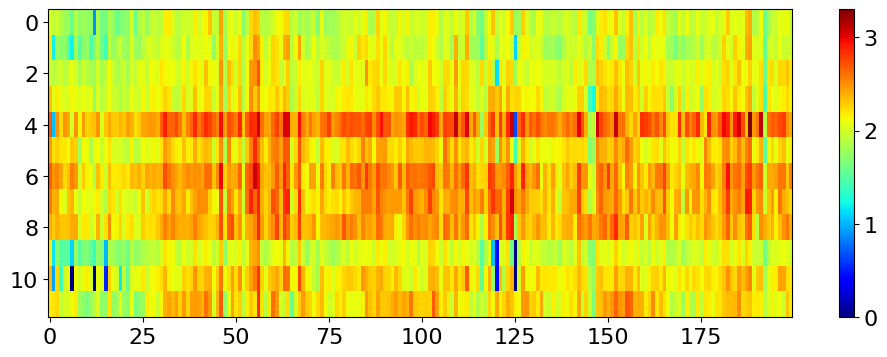

In [22]:
print(lh_data_parc['total'].shape)
plt.figure(figsize=(12,4))
plt.imshow(lh_data_parc['total'].T, cmap='jet', aspect='auto')
plt.colorbar()

#check if lh_data_parc['total'] has zeros or nans
print(np.sum(lh_data_parc['total'] == 0))
#find which one is zero
print(np.where(lh_data_parc['total'] == 0))
print(np.sum(np.isnan(lh_data_parc['total'])))  


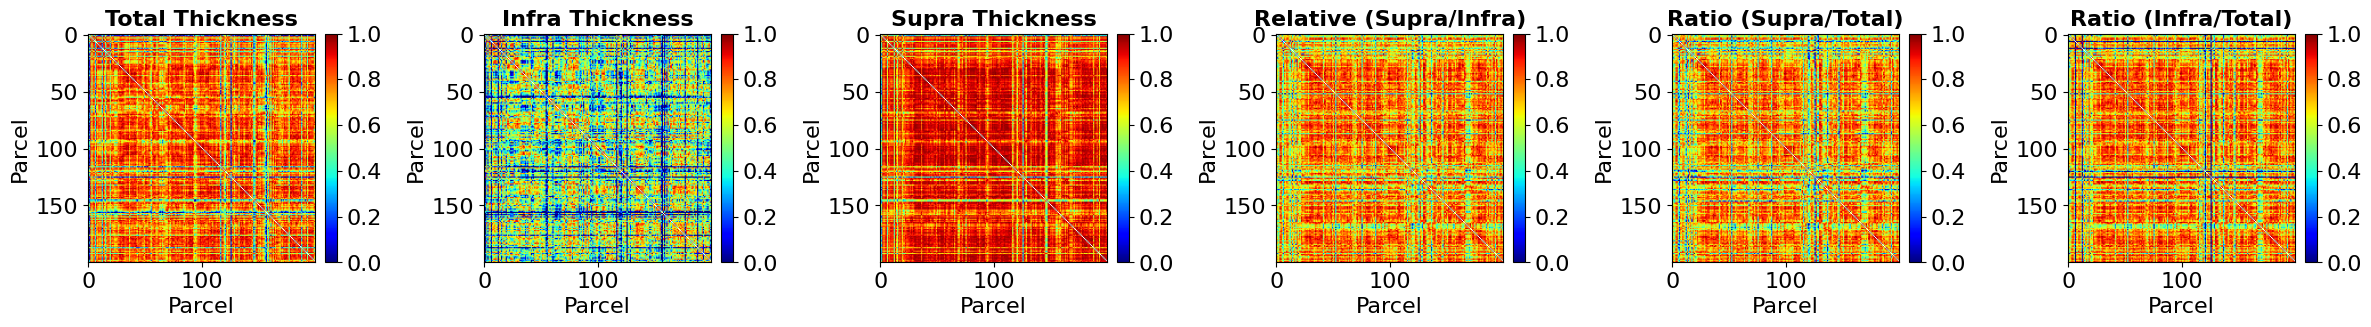

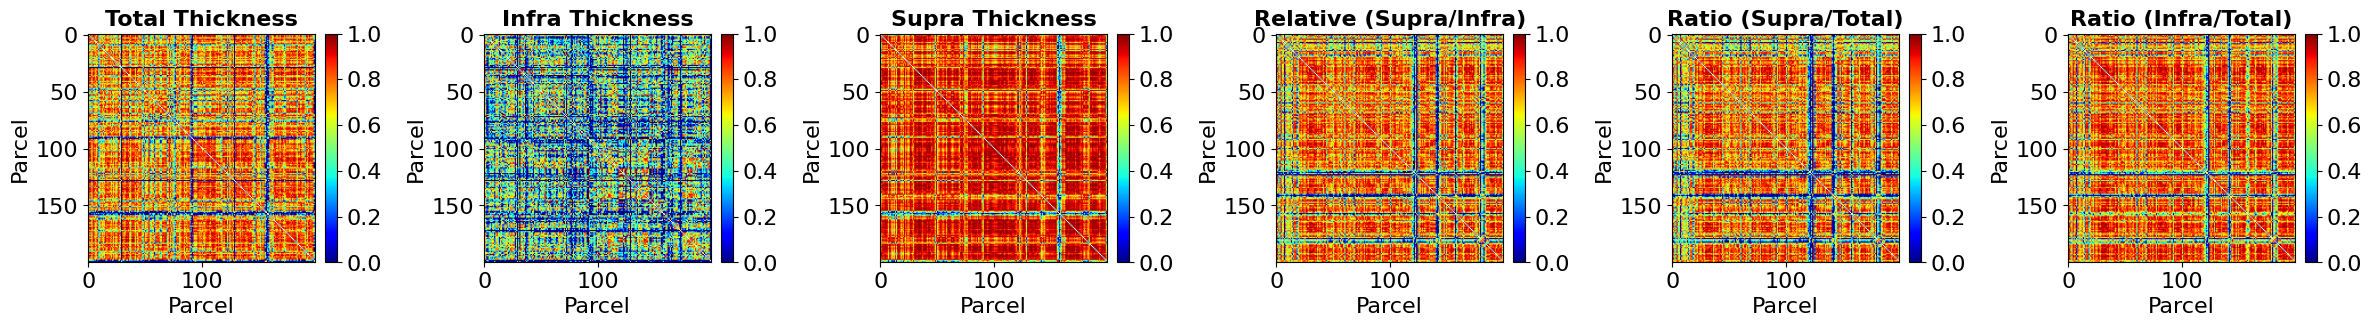

In [23]:
total_corr_lh, infra_corr_lh, supra_corr_lh, relative_corr_lh, ratio_supra_corr_lh, ratio_infra_corr_lh = plot_subject_similarity(lh_data_parc, transpose=False, partial_corr=False,vmin=0,vmax=1,cmap='jet')  
total_corr_rh, infra_corr_rh, supra_corr_rh, relative_corr_rh, ratio_supra_corr_rh, ratio_infra_corr_rh = plot_subject_similarity(rh_data_parc, transpose=False, partial_corr=False,vmin=0,vmax=1,cmap='jet')


In [ ]:

def plot_sparsity_analysis(data, title_prefix):
    plt.figure(figsize=(32,8))
    for i, sparsity_i in enumerate(np.arange(0.1,1,0.1)):
        plt.subplot(2,5,i+1)
        affinity = compute_affinity(data, kernel='normalized_angle', sparsity=sparsity_i)
        affinity[np.eye(affinity.shape[0]) == 1] = np.nan
        plt.imshow(affinity,'jet')
        plt.title(f'{title_prefix} Sparsity: {sparsity_i:.1f}', fontsize=18)
        plt.clim(0.5, 1)
        plt.colorbar(shrink=1)


#plt.rcParams.update({'font.size': 16})
#plot_sparsity_analysis(data2plot_lh, 'LH')
#plot_sparsity_analysis(data2plot_rh, 'RH')


In [ ]:
def calculate_gradients_from_brainspace(data2plot, mask_indices, atlas_data, hemisphere_mask, n_components, g_sparsity = 0.9):
    """Process gradient maps for one hemisphere"""
    gm_all = []
    grad_all = []
   
    
    #for i, _ in enumerate(radii):
    # Fit gradient maps
    gm = GradientMaps(n_components, approach='dm', kernel='normalized_angle')
    
    if np.isnan(mask_indices).all():
        print('no mask')
        gm.fit(np.nan_to_num(data2plot, 0),sparsity = g_sparsity)#sparsity density is 0.9 by default
    else:
        mask = np.ones(data2plot.shape[0], dtype=bool)
        mask[mask_indices] = False
        gm.fit(data2plot, sparsity = g_sparsity)

    gm_all.append(gm)
    
    # Process gradients
    grad = []
    
    for j in range(n_components):
        data_len = len(data2plot)
        if np.isnan(mask_indices).all():
            tmp_gm = gm.gradients_[:,j]
        else:
            
            tmp_gm = np.full((data_len, 1), np.nan)
            tmp_gm[mask] = gm.gradients_[:,j].reshape(-1,1)
            tmp_gm = tmp_gm.ravel()
            
        atlas_slice = atlas_data
        min_val = np.min(atlas_slice[atlas_slice != 0])
        max_val = np.max(atlas_slice[atlas_slice != 0])
        #print(f"Atlas range: {min_val}-{max_val}")
        grad.append(map_to_labels(tmp_gm, atlas_slice, mask=hemisphere_mask, 
                                fill=np.nan, source_lab=np.arange(min_val,max_val+1)))
            
        grad_all.append(grad)
    
    return gm_all, grad_all


#this is the main funciton used for gradient alignment -092525 DJ
def align_gradients(X,Y,reflection=False,rotation=False):
    """Align source gradients to target gradients
        X: source gradients
        Y: target gradients
    """
    
    if len(X) != len(Y):
        raise ValueError("Lists must be same length")
    
    #set nan to 0
    X[np.isnan(X)] = 0
    Y[np.isnan(Y)] = 0

    print('X',X.shape)
    print('Y',Y.shape)

    #center the matrix
    X_centered = X - np.mean(X, axis=0)
    Y_centered = Y - np.mean(Y, axis=0)
    R, _ = orthogonal_procrustes(X_centered, Y_centered)

    print(reflection, rotation)
    if reflection == True and rotation == False:
        sign_matrix = np.sign(np.diag(R))  
        sign_transform = np.diag(sign_matrix)
        X_sign_corrected = X_centered @ sign_transform + np.mean(Y, axis=0)
        return X_sign_corrected, sign_transform
    elif reflection == True and rotation == True:
        X = X_centered @ R + np.mean(Y, axis=0)
        return X, R
    else:
        raise ValueError("Invalid combination of reflection and rotation")
   
  

def unmap_gradient(grad_all_aligned, mask_indices, atlas_data, hemisphere_mask, start_idx, end_idx):
    """Unmap gradients to atlas data"""
    grad_all_unmapped = []
    for i, gm in enumerate(gm_all):
        grad = []
        for j in range(N_components):
            tmp_gm = gm.gradients_[:,j] if np.isnan(mask_indices).all() else \
                    np.full(len(data2plot[i]), np.nan)
            
            # Apply mask if needed
            if not np.isnan(mask_indices).all():
                mask = np.ones(data2plot[i].shape[0], dtype=bool)
                mask[mask_indices] = False
                tmp_gm[mask] = gm.gradients_[:,j]
            
            # Map to atlas labels
            atlas_slice = atlas_data[start_idx:end_idx]
            nonzero = atlas_slice[atlas_slice != 0]
            grad.append(label_to_map(tmp_gm, atlas_slice, mask=hemisphere_mask,
                                    fill=np.nan, source_lab=np.arange(nonzero.min(), nonzero.max()+1)))
    return grad

def map_gradients(gm_all, data2plot, mask_indices, atlas_data, hemisphere_mask, start_idx, end_idx):
    """Map gradients to atlas data"""
    grad_all_aligned = []
    for i, gm in enumerate(gm_all):
        grad = []
        for j in range(N_components):
            # Get gradient data
            tmp_gm = gm.gradients_[:,j] if np.isnan(mask_indices).all() else \
                    np.full(len(data2plot[i]), np.nan)
            
            # Apply mask if needed
            if not np.isnan(mask_indices).all():
                mask = np.ones(data2plot[i].shape[0], dtype=bool)
                mask[mask_indices] = False
                tmp_gm[mask] = gm.gradients_[:,j]
            
            # Map to atlas labels
            atlas_slice = atlas_data[start_idx:end_idx]
            nonzero = atlas_slice[atlas_slice != 0]
            grad.append(map_to_labels(tmp_gm, atlas_slice, mask=hemisphere_mask,
                                    fill=np.nan, source_lab=np.arange(nonzero.min(), nonzero.max()+1)))
        grad_all_aligned.append(grad)
    return grad_all_aligned


def create_hemisphere_plots(grad_all_aligned, surf_file, hemi, N_components_plot,color_ranges):
    """Create plots for one hemisphere"""
    plotters = []

    for pc in range(N_components_plot):
        plotter = yaspy.Plotter(surf_file, hemi=hemi)
        #[0] is some radii parameter I used before.. 
        #m = np.nanmax(np.abs([grad_all_aligned[0][pc]]))   
        m = 0.1#color_ranges[pc] 
        overlay = plotter.overlay(grad_all_aligned[0][:,pc], cmap='RdBu_r', alpha=1, vmin=-m, vmax=m)
        plotter.border(grad_all_aligned[0][:,pc], alpha=0)
        plotters.append([plotter.screenshot("lateral"), plotter.screenshot("medial"), overlay])
        
    return plotters, m

In [26]:
# Load Hurst exponent data and correlation matrices
'''
he_corr = np.load('/Users/dennis.jungchildmind.org/Downloads/fmri_hurst_exponents_results_schaefer400_dfa_cov.npy', allow_pickle=True)
he_dat = np.load('/Users/dennis.jungchildmind.org/Downloads/fmri_hurst_exponents_results_schaefer400_dfa.npy', allow_pickle=True)
print(f"Hurst exponent data shape: {he_dat.shape}")

# Split correlation matrices into left and right hemispheres
he_corr_lh = {0: he_corr[0:200, 0:200]}
he_corr_rh = {0: he_corr[200:400, 200:400]}

# Calculate mean Hurst exponents and map to surface for each hemisphere
# Left hemisphere
he_dat_lh = np.mean(he_dat[:,0:200], axis=0)
mapped_lh = map_to_labels(he_dat_lh, atlas[0:32492], mask=mask_lh, fill=np.nan, source_lab=np.arange(1,201))

# Right hemisphere 
he_dat_rh = np.mean(he_dat[:,200:], axis=0)
mapped_rh = map_to_labels(he_dat_rh, atlas[32492:], mask=mask_rh, fill=np.nan, source_lab=np.arange(201,401))

# Get global min/max for consistent colorbar
vmin = min(np.nanmin(mapped_lh), np.nanmin(mapped_rh))
vmax = max(np.nanmax(mapped_lh), np.nanmax(mapped_rh))

# Plot functions
def plot_hemisphere(mapped_data, surf_file, hemi, vmin, vmax):
    plotter = yaspy.Plotter(surf_file, hemi=hemi)
    im1 = plotter.overlay(mapped_data, cmap='jet', alpha=1, vmin=vmin, vmax=vmax)
    plotter.border(mapped_data, alpha=0)
    lateral = plotter.screenshot("lateral")
    medial = plotter.screenshot("medial")
    
    # Create figure with lateral and medial views
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(2,4))
    ax1.imshow(lateral)
    ax1.axis('off')
    ax2.imshow(medial)
    ax2.axis('off')
    
    # Add colorbar
    divider = make_axes_locatable(ax1)
    cax = divider.append_axes("bottom", size="5%", pad=0.5)
    plt.colorbar(im1, cax=cax, orientation='horizontal')
    
    plt.tight_layout()
    plt.show()

# Plot left hemisphere
plot_hemisphere(
    mapped_lh,
    '/Users/dennis.jungchildmind.org/Downloads/HCP_S1200_Atlas_Z4_pkXDZ/S1200.L.white_MSMAll.32k_fs_LR.surf.gii',
    'lh',
    vmin,
    vmax
)

# Plot right hemisphere
plot_hemisphere(
    mapped_rh,
    '/Users/dennis.jungchildmind.org/Downloads/HCP_S1200_Atlas_Z4_pkXDZ/S1200.R.white_MSMAll.32k_fs_LR.surf.gii',
    'rh',
    vmin,
    vmax
)
print(he_corr_rh[0].shape)
print(he_corr_lh[0].shape)
plt.imshow(he_corr,cmap='RdBu_r',vmin=-1,vmax=1)
plt.colorbar()
print()
#plot vertical and horizontal lines at half of the matrix
plt.axvline(x=he_corr.shape[0]/2, color='black', linestyle='-')
plt.axhline(y=he_corr.shape[1]/2, color='black', linestyle='-')

#arrange xtickslabel from 1 to 400 and ytickslabel from 1 to 400
plt.xticks(np.arange(0, 401, 50), labels=np.arange(0, 401, 50))
plt.yticks(np.arange(0, 401, 50), labels=np.arange(0, 401, 50))
plt.show()


'''


'\nhe_corr = np.load(\'/Users/dennis.jungchildmind.org/Downloads/fmri_hurst_exponents_results_schaefer400_dfa_cov.npy\', allow_pickle=True)\nhe_dat = np.load(\'/Users/dennis.jungchildmind.org/Downloads/fmri_hurst_exponents_results_schaefer400_dfa.npy\', allow_pickle=True)\nprint(f"Hurst exponent data shape: {he_dat.shape}")\n\n# Split correlation matrices into left and right hemispheres\nhe_corr_lh = {0: he_corr[0:200, 0:200]}\nhe_corr_rh = {0: he_corr[200:400, 200:400]}\n\n# Calculate mean Hurst exponents and map to surface for each hemisphere\n# Left hemisphere\nhe_dat_lh = np.mean(he_dat[:,0:200], axis=0)\nmapped_lh = map_to_labels(he_dat_lh, atlas[0:32492], mask=mask_lh, fill=np.nan, source_lab=np.arange(1,201))\n\n# Right hemisphere \nhe_dat_rh = np.mean(he_dat[:,200:], axis=0)\nmapped_rh = map_to_labels(he_dat_rh, atlas[32492:], mask=mask_rh, fill=np.nan, source_lab=np.arange(201,401))\n\n# Get global min/max for consistent colorbar\nvmin = min(np.nanmin(mapped_lh), np.nanmin(map

In [ ]:
# Create dictionaries with simpler keys for data types
metrics = ['total', 'supra', 'infra', 'ratio_supra', 'ratio_infra', 'relative']#,'he']
N_components = 10
N_components_plot = 10
G_sparsity = 0.9 #sparsity paramter for brainspace (Default is 0.9)

#paraemters for alignment
align_across_hemi = True
align_to_hcp = False
#rotation 
do_rotation = False #says don't do rotation
do_reflection = True
#mask?
mask_index_lh = np.nan
mask_index_rh = np.nan

# Initialize dictionaries for left and right hemispheres
lh_data_all = {m: {} for m in metrics}
rh_data_all = {m: {} for m in metrics}
lh_aligned_all = {m: {} for m in metrics}
rh_aligned_all = {m: {} for m in metrics}
#rotation matrices
R_lh_all = {m: {} for m in metrics}
R_rh_all = {m: {} for m in metrics}
R_lh_aligned_all = {m: {} for m in metrics}
R_rh_aligned_all = {m: {} for m in metrics}


for metric in metrics:
    print(metric)
    # Get data for current metric
    data2plot_lh = eval(f"{metric}_corr_lh")[0]
    data2plot_rh = eval(f"{metric}_corr_rh")[0]
    # Create hemisphere masks
    atlasDat = atlas
    mask_lh = atlas_data_lh != 0
    mask_rh = atlas_data_rh != 0

    # calculate gradients using brainspace toolbox
    # make sure to adjust the G_sparsity parameter, which sets the sparsity for the affinity matrix
    gm_all_lh, grad_all_lh = calculate_gradients_from_brainspace(data2plot_lh, mask_index_lh, atlas_data_lh, mask_lh, N_components, G_sparsity)
    gm_all_rh, grad_all_rh = calculate_gradients_from_brainspace(data2plot_rh, mask_index_rh, atlas_data_rh, mask_rh, N_components, G_sparsity)
    #def plot_eigenvalues(gm_aligned, color='#2E86C1',metrics=None,save=False,SAVEFOLDER='./figures/eigenvalues'):
    plot_eigenvalues(gm_all_lh, filename=f'{metric}_eigenvalues_lh_sparsity{G_sparsity}',save=True)
    plot_eigenvalues(gm_all_rh, filename=f'{metric}_eigenvalues_rh_sparsity{G_sparsity}',save=True)
    
   # if align_across_hemi:
    if align_across_hemi:
        grad_all_aligned_hemi_lh, R_lh = align_gradients(np.array(grad_all_lh[0]).T, np.array(grad_all_lh[0]).T, reflection=do_reflection, rotation=do_rotation)
        grad_all_aligned_hemi_rh, R_rh = align_gradients(np.array(grad_all_rh[0]).T, np.array(grad_all_lh[0]).T, reflection=do_reflection, rotation=do_rotation)
        print('aligned across hemi')
    else:
        #don't 
        grad_all_aligned_hemi_lh, R_lh = align_gradients(np.array(grad_all_lh[0]).T, np.array(grad_all_lh[0]).T, reflection=do_reflection, rotation=do_rotation)
        grad_all_aligned_hemi_rh, R_rh = align_gradients(np.array(grad_all_rh[0]).T, np.array(grad_all_rh[0]).T, reflection=do_reflection, rotation=do_rotation)
        

    grad_all_aligned_lh = []
    grad_all_aligned_rh = []
    R_lh_hcp = []
    R_rh_hcp = []

    
     #align to total
    if metric != 'total':
        print('aligning to total')
        grad_all_aligned_lh, R_lh = align_gradients(grad_all_aligned_hemi_lh, lh_data_all['total'][0],reflection=do_reflection, rotation=do_rotation)
        grad_all_aligned_rh, R_rh = align_gradients(grad_all_aligned_hemi_rh, rh_data_all['total'][0],reflection=do_reflection, rotation=do_rotation)
    else:
        print('aligning to total')
        grad_all_aligned_lh, R_lh = align_gradients(grad_all_aligned_hemi_lh, grad_all_aligned_hemi_lh,reflection=do_reflection, rotation=do_rotation)
        #align righ hemishere to lh
        grad_all_aligned_rh, R_rh = align_gradients(grad_all_aligned_hemi_rh, grad_all_aligned_hemi_lh,reflection=do_reflection, rotation=do_rotation)

    # Store aligned 
    lh_aligned_all[metric][0] = grad_all_aligned_lh
    rh_aligned_all[metric][0] = grad_all_aligned_rh
    R_lh_aligned_all[metric][0] = R_lh_hcp
    R_rh_aligned_all[metric][0] = R_rh_hcp


    #Not aligned to HCP but aligned across hemispehres
    lh_data_all[metric][0] = grad_all_aligned_hemi_lh
    rh_data_all[metric][0] = grad_all_aligned_hemi_rh
    R_lh_all[metric][0] = R_lh
    R_rh_all[metric][0] = R_rh
    
    

total
no mask
no mask
X (32492, 10)
Y (32492, 10)
True False
X (32492, 10)
Y (32492, 10)
True False
aligned across hemi
aligning to total
X (32492, 10)
Y (32492, 10)
True False
X (32492, 10)
Y (32492, 10)
True False
supra
no mask
no mask
X (32492, 10)
Y (32492, 10)
True False
X (32492, 10)
Y (32492, 10)
True False
aligned across hemi
aligning to total
X (32492, 10)
Y (32492, 10)
True False
X (32492, 10)
Y (32492, 10)
True False
infra
no mask
no mask
X (32492, 10)
Y (32492, 10)
True False
X (32492, 10)
Y (32492, 10)
True False
aligned across hemi
aligning to total
X (32492, 10)
Y (32492, 10)
True False
X (32492, 10)
Y (32492, 10)
True False
ratio_supra
no mask
no mask
X (32492, 10)
Y (32492, 10)
True False
X (32492, 10)
Y (32492, 10)
True False
aligned across hemi
aligning to total
X (32492, 10)
Y (32492, 10)
True False
X (32492, 10)
Y (32492, 10)
True False
ratio_infra
no mask
no mask
X (32492, 10)
Y (32492, 10)
True False
X (32492, 10)
Y (32492, 10)
True False
aligned across hemi
alig

Aligned across hemi reflection and/or rotation matrix being plotted
Plotting left hemisphere


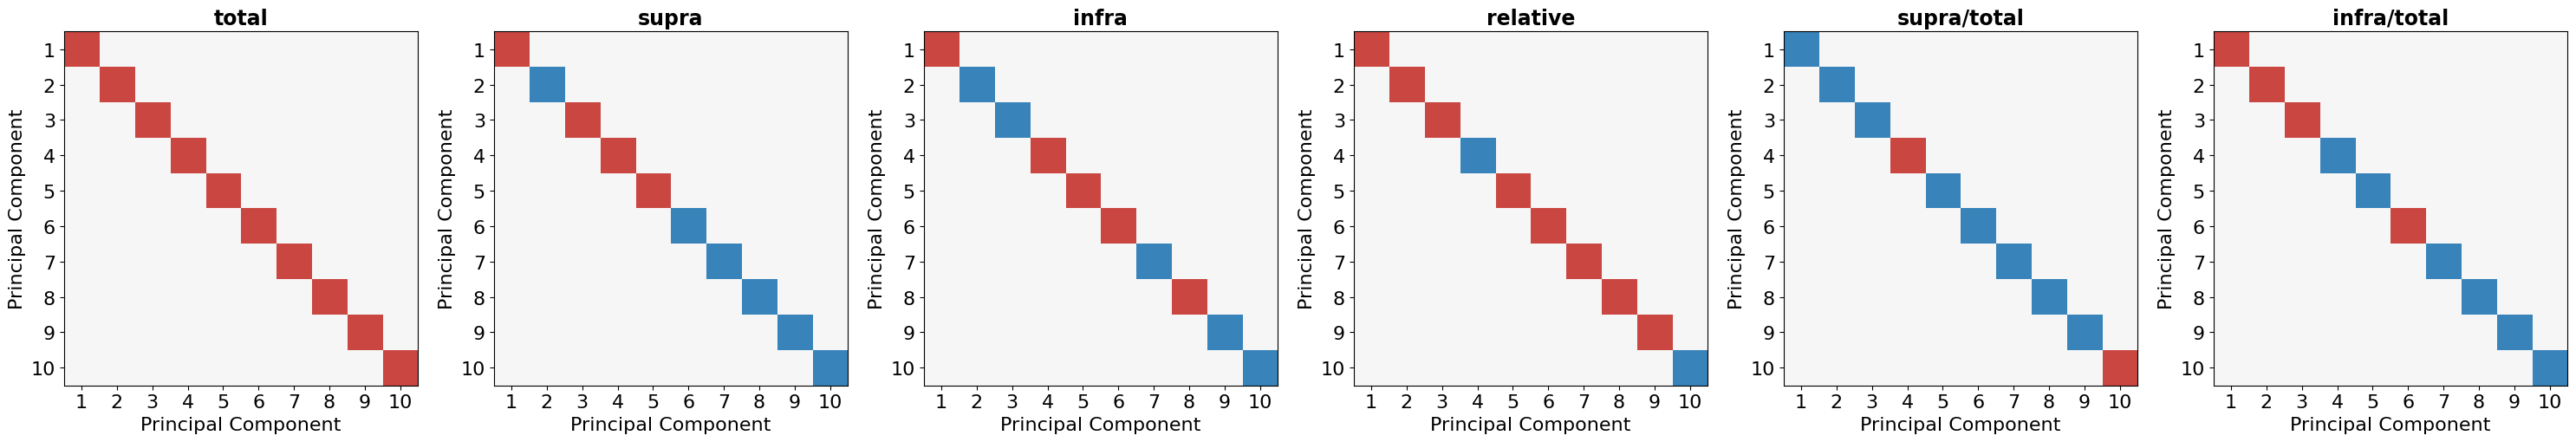

Plotting right hemisphere


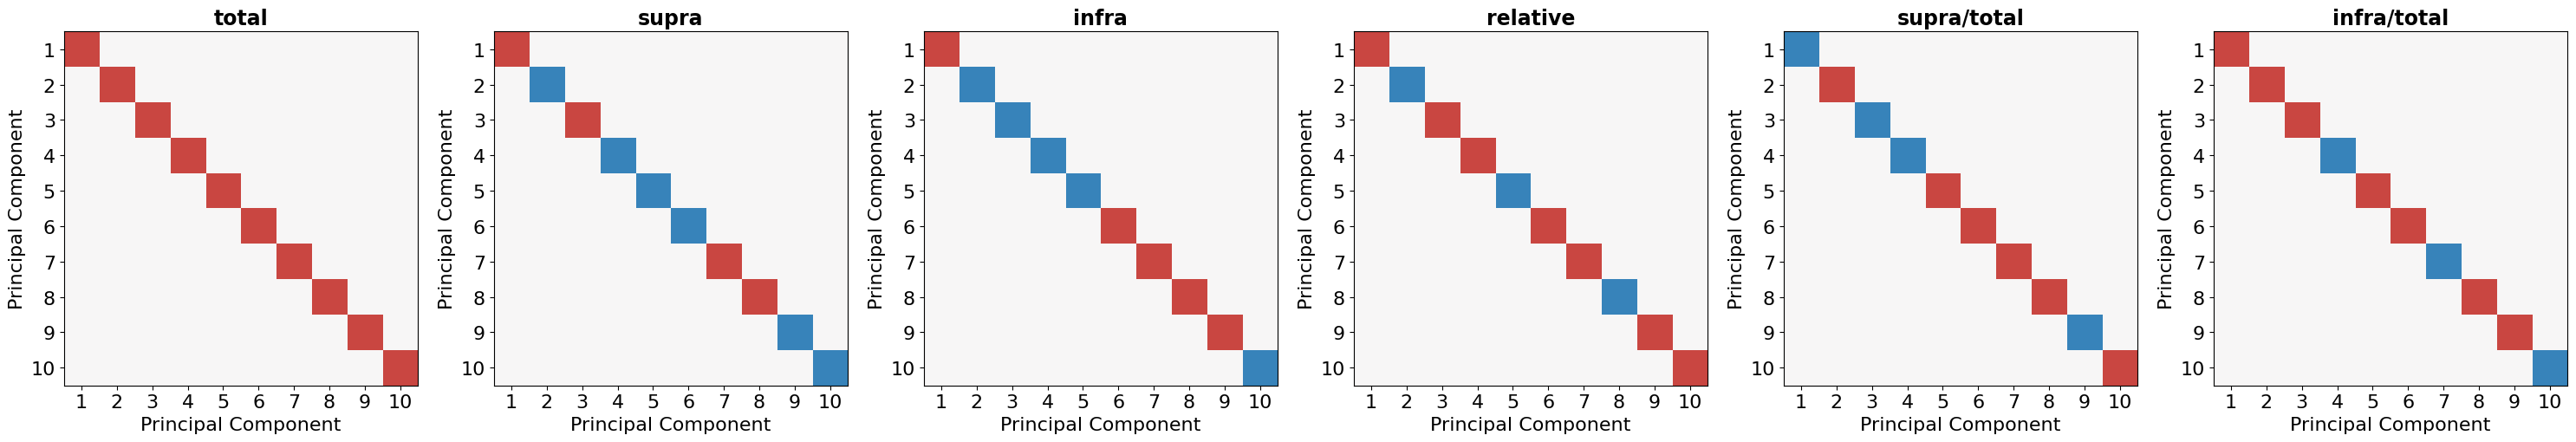

In [ ]:
# Calculate similarity matrices across data types for first 3 PCs
data_types = ['total','supra', 'infra', 'relative', 'ratio_supra', 'ratio_infra']#,'diff']
title_labels = ['total','supra', 'infra', 'relative', 'supra/total', 'infra/total']#,'diff']

plot_dat_lh = []
plot_dat_rh = []


print('Aligned across hemi reflection and/or rotation matrix being plotted')
plot_dat_lh = R_lh_all
plot_dat_rh = R_rh_all


# Plot both hemispheres
for hemi_name, plot_dat in [('left hemisphere', plot_dat_lh), ('right hemisphere', plot_dat_rh)]:
    print(f'Plotting {hemi_name}')
    fig, axes = plt.subplots(1, len(data_types), figsize=(5*len(data_types), 10))

    for i,dtype in enumerate(data_types):
        ax = axes[i]
        im = ax.imshow(plot_dat[dtype][0],cmap='RdBu_r',vmin=-1.5,vmax=1.5)
        ax.set_title(title_labels[i], fontsize=17, fontweight='bold')
        
        # Add labels
        ax.set_xticks(np.arange(0,10))
        ax.set_xticklabels(np.arange(1,11),fontsize=16)
        ax.set_xlabel('Principal Component',fontsize=16)
        ax.set_yticks(np.arange(0,10))
        ax.set_yticklabels(np.arange(1,11),fontsize=16)
        ax.set_ylabel('Principal Component',fontsize=16)
        # Add colorbar
        #cbar = plt.colorbar(im, ax=ax)
        #cbar.ax.tick_params(labelsize=14)

    plt.tight_layout()
    plt.show()

In [29]:
# Calculate similarity matrices across data types for first 3 PCs
data_types = ['total','supra', 'infra', 'relative', 'ratio_supra', 'ratio_infra']#,'diff',]
tick_labels = ['total','supra', 'infra', 'supra/infra', 'supra/total', 'infra/total']#,'diff']

num_pca_plot = 3
#save subfolder 
SAVEFOLDER = './figures/gradient_corr_mat'
# Helper function to process and plot correlation matrices
def plot_correlation_matrix(data_dict, pc_index, ax, hemisphere):
    # Concatenate data for all types
    tmp_data = None
    for data_type in data_types:
        data = data_dict[data_type][0][:,pc_index].reshape(-1,1)
        tmp_data = data if tmp_data is None else np.concatenate((tmp_data, data), axis=1)
    
    # Calculate and plot correlations
    corr_mat = np.corrcoef(tmp_data.T)
    im = ax.imshow(corr_mat, cmap='RdBu_r', vmin=-1, vmax=1)
    ax.set_title(f'PC {pc_index+1}', fontsize=17, fontweight='bold')
    
    # Add labels
    ax.set_xticks(np.arange(len(tick_labels)))
    ax.set_yticks(np.arange(len(tick_labels)))
    ax.set_xticklabels(tick_labels, rotation=45, ha='right', fontsize=16)
    ax.set_yticklabels(tick_labels, fontsize=16)
    
    # Add colorbar
    cbar = plt.colorbar(im, ax=ax)
    cbar.ax.tick_params(labelsize=14)
    
    return im




# Plot correlation matrices for the unaligned
fig, axes = plt.subplots(1, num_pca_plot*2, figsize=(10*num_pca_plot, 4))
print('displaying unaligned data')
for pc_index in range(num_pca_plot):
    # Left hemisphere
    plot_correlation_matrix(lh_data_all, pc_index, axes[pc_index], 'LH')
    
    # Right hemisphere 
    plot_correlation_matrix(rh_data_all, pc_index, axes[pc_index + num_pca_plot], 'RH')

plt.tight_layout()
#if the save folder exists, save the figure
if not os.path.exists(SAVEFOLDER):
    os.makedirs(SAVEFOLDER)
plt.savefig(os.path.join(SAVEFOLDER, f'unaligned_corr_mat_sparsity{G_sparsity}.png'), dpi=300)
plt.close()





displaying unaligned data


In [49]:
print(R_lh_all['supra'][0])
print(linear_sum_assignment(np.abs(R_lh_all['supra'][0])))
print(lh_aligned_all['supra'][0].shape)

[[ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0. -1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0. -1.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0. -1.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0. -1.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0. -1.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0. -1.]]
(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([1, 0, 3, 2, 5, 4, 7, 6, 9, 8]))
(32492, 10)


In [ ]:
from scipy.optimize import linear_sum_assignment

def reorder_data(data_dict, rot_matrix,reference_key='total', n_components=N_components):
    """Reorder components of each metric to maximize correlation with reference."""
    reordered_data = {}
    reorder_map = {}
    
    for key in data_dict.keys():
        # Correlate current metric with reference
        #C = np.corrcoef(data_dict[reference_key][0].T, data_dict[key][0].T, rowvar=True)
        # C = C[n_components:, 0:n_components]
        C = rot_matrix[key][0]
      # 
        
        '''ConnectionError
        # Find optimal assignment using Hungarian algorithm
        row_ind, col_ind = linear_sum_assignment(-np.abs(C))  # Negative for maximization
        
        # Store reordered data and mapping
        reordered_data[key] = [data_dict[key][0][:, col_ind]]
        reorder_map[key] = col_ind
        
        # Print reordering details
        print(f"\nReordering for {key}:")
        for i, (total_comp, metric_comp) in enumerate(zip(row_ind, col_ind)):
            correlation = C[total_comp, metric_comp]
            print(f"Total gradient {total_comp} ↔ {key} gradient {metric_comp} (r = {correlation:.3f})")
        
    return reordered_data, reorder_map
    '''
    return reordered_data

# Reorder left and right hemisphere data
lh_data_all_reordered, reorder_map_lh = reorder_data(lh_aligned_all,R_lh_all)
rh_data_all_reordered, reorder_map_rh = reorder_data(rh_aligned_all,R_rh_all)



Reordering for total:
Total gradient 0 ↔ total gradient 0 (r = 1.000)
Total gradient 1 ↔ total gradient 1 (r = 1.000)
Total gradient 2 ↔ total gradient 2 (r = 1.000)
Total gradient 3 ↔ total gradient 3 (r = 1.000)
Total gradient 4 ↔ total gradient 4 (r = 1.000)
Total gradient 5 ↔ total gradient 5 (r = 1.000)
Total gradient 6 ↔ total gradient 6 (r = 1.000)
Total gradient 7 ↔ total gradient 7 (r = 1.000)
Total gradient 8 ↔ total gradient 8 (r = 1.000)
Total gradient 9 ↔ total gradient 9 (r = 1.000)

Reordering for supra:
Total gradient 0 ↔ supra gradient 0 (r = 1.000)
Total gradient 1 ↔ supra gradient 1 (r = -1.000)
Total gradient 2 ↔ supra gradient 2 (r = 1.000)
Total gradient 3 ↔ supra gradient 3 (r = 1.000)
Total gradient 4 ↔ supra gradient 4 (r = 1.000)
Total gradient 5 ↔ supra gradient 5 (r = -1.000)
Total gradient 6 ↔ supra gradient 6 (r = -1.000)
Total gradient 7 ↔ supra gradient 7 (r = -1.000)
Total gradient 8 ↔ supra gradient 8 (r = -1.000)
Total gradient 9 ↔ supra gradient 9 (

In [48]:
print(reorder_map_lh)

{'total': array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), 'supra': array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), 'infra': array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), 'ratio_supra': array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), 'ratio_infra': array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), 'relative': array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])}


(32492, 10)
(32492, 10)


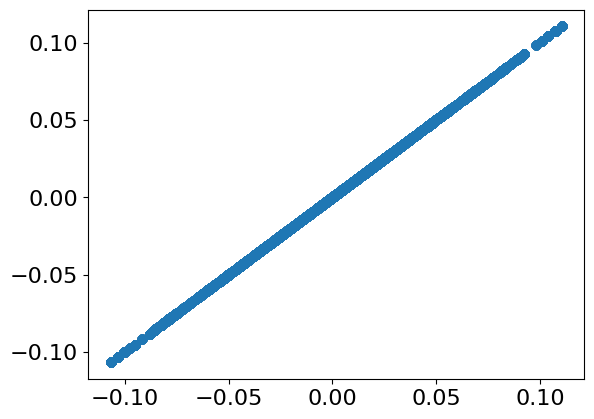

In [41]:
print(lh_data_all_reordered['supra'][0].shape)
print(lh_aligned_all['supra'][0].shape)
plt.scatter(lh_data_all_reordered['supra'][0],lh_aligned_all['supra'][0])

In [31]:
#Unaligned data 
print('displaying unaligned data (not reordered)')
N_components_plot = 3
labelsize = 10
SAVEFOLDER = f'./figures/gradients/sparsity{G_sparsity}'
#for data_type in lh_data_all.keys():
for data_type in metrics:
    print(data_type)
    grad2plot_lh = lh_aligned_all[data_type]
    grad2plot_rh = rh_aligned_all[data_type]
    #color_ranges_lh = [np.nanmax(np.abs([grad2plot_lh[0][:,pc]])) for pc in range(N_components_plot)]
    #color_ranges_rh = [np.nanmax(np.abs([grad2plot_rh[0][:,pc]])) for pc in range(N_components_plot)]
    color_ranges_lh = [np.percentile(([grad2plot_lh[0][:,pc]]),95) for pc in range(N_components_plot)]
    color_ranges_rh = [np.percentile(([grad2plot_rh[0][:,pc]]),95) for pc in range(N_components_plot)]

    plotters_lh, m_lh = create_hemisphere_plots(
        grad2plot_lh,
        '/Users/dennis.jungchildmind.org/Downloads/HCP_S1200_Atlas_Z4_pkXDZ/S1200.L.white_MSMAll.32k_fs_LR.surf.gii',
        'lh',
        N_components_plot,
        color_ranges_lh
    )

    plotters_rh, m_rh = create_hemisphere_plots(
        grad2plot_rh,
        '/Users/dennis.jungchildmind.org/Downloads/HCP_S1200_Atlas_Z4_pkXDZ/S1200.R.white_MSMAll.32k_fs_LR.surf.gii',
        'rh',
        N_components_plot,
        color_ranges_rh
    )

    # Plot both hemispheres
    for hemi, plotters, color_ranges in [('LH', plotters_lh, color_ranges_lh), ('RH', plotters_rh, color_ranges_rh)]:
        f, (ax1, ax2) = plt.subplots(2, N_components_plot, figsize=(2*N_components_plot, 5))

        for pc in range(N_components_plot):
            # Create mappable object for colorbar
            im1 = ax1[pc].imshow(plotters[pc][0], cmap='RdBu_r', 
                                vmin=-color_ranges[pc], vmax=color_ranges[pc])
            ax1[pc].axis('off')
            ax1[pc].set_title(f'PC{pc+1}', fontsize=labelsize*2, fontweight='bold')
            
            im2 = ax2[pc].imshow(plotters[pc][1], cmap='RdBu_r',
                                vmin=-color_ranges[pc], vmax=color_ranges[pc])
            ax2[pc].axis('off')
            
            # Add colorbar between the plots
            divider = make_axes_locatable(ax1[pc])
            cax = divider.append_axes("bottom", size="5%", pad=0.5)
            cbar = plt.colorbar(im1, cax=cax, orientation='horizontal')
            cbar.ax.tick_params(labelsize=labelsize)  # Increase colorbar tick label size

        plt.tight_layout()
        #save figure and the save folder
        #make the save folder if it doesn't exist
        if not os.path.exists(SAVEFOLDER):
            os.makedirs(SAVEFOLDER)
        plt.savefig(os.path.join(SAVEFOLDER, f'{data_type}_{hemi.lower()}_unaligned_unordered.png'), dpi=300)
        plt.close()
        


displaying unaligned data (not reordered)
total
supra
infra
ratio_supra
ratio_infra
relative


In [32]:
#Unaligned data 
print('displaying unaligned data (Reordered)')
#for data_type in lh_data_all.keys():
for data_type in metrics:
    print(data_type)
    grad2plot_lh = lh_data_all_reordered[data_type]
    grad2plot_rh = rh_data_all_reordered[data_type]
    color_ranges_lh = [np.nanmax(np.abs([grad2plot_lh[0][:,pc]])) for pc in range(N_components_plot)]
    color_ranges_rh = [np.nanmax(np.abs([grad2plot_rh[0][:,pc]])) for pc in range(N_components_plot)]

    plotters_lh, m_lh = create_hemisphere_plots(
        grad2plot_lh,
        '/Users/dennis.jungchildmind.org/Downloads/HCP_S1200_Atlas_Z4_pkXDZ/S1200.L.white_MSMAll.32k_fs_LR.surf.gii',
        'lh',
        N_components_plot,
        color_ranges_lh
    )

    plotters_rh, m_rh = create_hemisphere_plots(
        grad2plot_rh,
        '/Users/dennis.jungchildmind.org/Downloads/HCP_S1200_Atlas_Z4_pkXDZ/S1200.R.white_MSMAll.32k_fs_LR.surf.gii',
        'rh',
        N_components_plot,
        color_ranges_rh
    )



      # Plot both hemispheres
    for hemi, plotters, color_ranges in [('LH', plotters_lh, color_ranges_lh), ('RH', plotters_rh, color_ranges_rh)]:
        f, (ax1, ax2) = plt.subplots(2, N_components_plot, figsize=(2*N_components_plot, 5))

        for pc in range(N_components_plot):
            # Create mappable object for colorbar
            im1 = ax1[pc].imshow(plotters[pc][0], cmap='RdBu_r', 
                                vmin=-color_ranges[pc], vmax=color_ranges[pc])
            ax1[pc].axis('off')
            ax1[pc].set_title(f'PC{pc+1}', fontsize=labelsize*2, fontweight='bold')
            
            im2 = ax2[pc].imshow(plotters[pc][1], cmap='RdBu_r',
                                vmin=-color_ranges[pc], vmax=color_ranges[pc])
            ax2[pc].axis('off')
            
            # Add colorbar between the plots
            divider = make_axes_locatable(ax1[pc])
            cax = divider.append_axes("bottom", size="5%", pad=0.5)
            cbar = plt.colorbar(im1, cax=cax, orientation='horizontal')
            cbar.ax.tick_params(labelsize=labelsize)  # Increase colorbar tick label size

        plt.tight_layout()
        #save figure and the save folder
        #make the save folder if it doesn't exist
        if not os.path.exists(SAVEFOLDER):
            os.makedirs(SAVEFOLDER)
        plt.savefig(os.path.join(SAVEFOLDER, f'{data_type}_{hemi.lower()}_unaligned_reordered.png'), dpi=300)
        plt.close()
        

displaying unaligned data (Reordered)
total
supra


Context leak detected, msgtracer returned -1


infra
ratio_supra
ratio_infra
relative


Context leak detected, msgtracer returned -1


In [34]:
#in a large figure we are going to combine all figures to compare the notreordered and reordere figures
num_cols = len(data_types)
num_rows = 2
title_fontsize = 10

for HEMI in ['lh','rh']:
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols*3, 3*num_rows))

    for i, data_type in enumerate(data_types):
        # Load the unreordered figure
        unordered_path = os.path.join(SAVEFOLDER, f'{data_type}_{HEMI}_unaligned_unordered.png')
        unordered_img = plt.imread(unordered_path)
        
        # Load the reordered figure
        reordered_path = os.path.join(SAVEFOLDER, f'{data_type}_{HEMI}_unaligned_reordered.png')
        reordered_img = plt.imread(reordered_path)

        # Display unreordered image in top row
        axes[0, i].imshow(unordered_img)
        axes[0, i].axis('off')
        axes[0, i].set_title(f'{data_type} (unordered)', fontsize=title_fontsize, fontweight='bold')
        
        # Display reordered image in bottom row
        axes[1, i].imshow(reordered_img)
        axes[1, i].axis('off')
        axes[1, i].set_title(f'{data_type} (reordered)', fontsize=title_fontsize, fontweight='bold')

    plt.tight_layout()
    plt.savefig(os.path.join(SAVEFOLDER, f'{HEMI}_combined_unordered_vs_reordered.png'), dpi=300, bbox_inches='tight')
    plt.close()
        





In [ ]:
# Unmap gradient data to parcel level for both hemispheres
lh_data_all_unmapped = {}
rh_data_all_unmapped = {}

# Process left hemisphere
for data_type in lh_data_all.keys():
    mapped_grad = lh_data_all[data_type][0]
    mapped_grad = lh_aligned_all[data_type][0]
    atlasDat_lh = atlasDat[:32492]
    unmapped_grad = np.zeros((np.max(atlasDat_lh)-np.min(atlasDat_lh[atlasDat_lh != 0])+1, mapped_grad.shape[1]))
    for i, parcel in enumerate(range(np.min(atlasDat_lh[atlasDat_lh != 0]), np.max(atlasDat_lh)+1)):
        unmapped_grad[i,:] = np.median(mapped_grad[atlasDat_lh == parcel,:], axis=0)
    lh_data_all_unmapped[data_type] = unmapped_grad

# Process right hemisphere 
for data_type in rh_data_all.keys():
    mapped_grad = rh_data_all[data_type][0]
    mapped_grad = rh_aligned_all[data_type][0]
    atlasDat_rh = atlasDat[32492:]
    unmapped_grad = np.zeros((np.max(atlasDat_rh)-np.min(atlasDat_rh[atlasDat_rh != 0])+1, mapped_grad.shape[1]))
    for i, parcel in enumerate(range(np.min(atlasDat_rh[atlasDat_rh != 0]), np.max(atlasDat_rh)+1)):
        unmapped_grad[i,:] = np.median(mapped_grad[atlasDat_rh == parcel,:], axis=0)
    rh_data_all_unmapped[data_type] = unmapped_grad


In [ ]:
#Gradients versus Gradients (but jt seems like they want in parcel level not vertex level)
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt

# Configuration
nPC = 0# 0 is the first PC
font_size = 24
tick_size = 20
data_type_ref_x = 'total'

for hemi in ['lh','rh']:

    if hemi == 'lh':
        gradient_data = lh_data_all_unmapped
    else:
        gradient_data = rh_data_all_unmapped

   
    data_types = [key for key in gradient_data.keys() if key != 'diff' and key != 'ratio_supra' and key != 'ratio_infra' and key != 'relative' and key != data_type_ref_x]
    n_plots = len(data_types)

    # Plot settings
    sns.set_style("white")
    sns.set_context("paper", font_scale=1.2)
    

    # Create figure and grid
    fig = plt.figure(figsize=(8*n_plots, 8))
    # Increase spacing between subplots
    gs = fig.add_gridspec(3, 3*n_plots, hspace=0.6, wspace=0.4)



    def get_title_name(data_type):
        titles = {
            'diff': f'G{nPC+1}(Symmetry)',
            'ratio_supra': f'G{nPC+1}(Supra/Total Ratio)',
            'ratio_infra': f'G{nPC+1}(Infra/Total Ratio)', 
            'relative': f'G{nPC+1}(Relative)',
            'he': f'G{nPC+1}(Hurst Exponent)',
            'supra': f'G{nPC+1}(Supra Thickness)',
            'infra': f'G{nPC+1}(Infra Thickness)',
            'total': f'G{nPC+1}(Total Thickness)'
        }
        return titles.get(data_type, '')


    def get_data_for_hemisphere(hemi, data_type_ref_x, gradient_data, data_type, nPC, atlas, atlas_to_network):
        if hemi == 'lh':
            #mask = atlas[0:32492].astype(bool)
            gradient_ref = gradient_data[data_type_ref_x][:,nPC]
            gradient = gradient_data[data_type][:,nPC]
            data_label_color = np.array(atlas_to_network[1:int(len(atlas_to_network)/2+1)])
            atlas_dat = atlas[:32492]
            atlas_min = np.min(atlas_dat[atlas_dat != 0])
            atlas_max = np.max(atlas_dat[atlas_dat != 0])
            new_data_label_color = []

            print(data_label_color.shape)
            for i,parcel in enumerate(range(atlas_min,atlas_max+1)):
                print(parcel)
                median_color = np.median(data_label_color[atlas_dat == parcel,:],axis=0)
                print(median_color)
                new_data_label_color.append(tuple(median_color.tolist()))
            data_label_color = new_data_label_color
        else:
            #mask = atlas[32492:].astype(bool)
            gradient_ref = gradient_data[data_type_ref_x][:,nPC]
            gradient = gradient_data[data_type][:,nPC]
            data_label_color = np.array(atlas_to_network[int(len(atlas_to_network)/2):])
            atlas_dat = atlas[32492:]
            atlas_min = np.min(atlas_dat[atlas_dat != 0])
            atlas_max = np.max(atlas_dat[atlas_dat != 0])
            new_data_label_color = []

            for i,parcel in enumerate(range(atlas_min,atlas_max+1)):
                median_color = np.median(data_label_color[atlas_dat == parcel,:],axis=0)
                new_data_label_color.append(tuple(median_color.tolist()))
            data_label_color = new_data_label_color


        return gradient_ref, gradient, data_label_color
    
    # Create network color mapping
    atlas_to_network = [yeo_network_colors[atlas[i]] for i in range(len(atlas))]

    # Plot each data type
    for plot_idx, data_type in enumerate(data_types):
        # Get data
        gradient_ref, gradient, data_label_color =get_data_for_hemisphere(
            hemi, data_type_ref_x, gradient_data, data_type, nPC, atlas, atlas_to_network
        )
        
        # Calculate correlation
        valid_mask = ~np.isnan(gradient_ref) & ~np.isnan(gradient)
        r, p = stats.pearsonr(gradient_ref[valid_mask], gradient[valid_mask])
        print(f"{data_type}: r={r:.2f}, p={p:.2e}")
        
        # Plot layout
        col_start = 3 * plot_idx
        col_end = col_start + 2
        
        # Main scatter plot
        ax_scatter = fig.add_subplot(gs[1:, col_start:col_end])
        sns.scatterplot(x=gradient_ref, y=gradient, alpha=1, s=60,
                        c=data_label_color,edgecolor='None', ax=ax_scatter)
        
        # Add regression line and correlation text
        sns.regplot(x=gradient_ref, y=gradient, scatter=False, color='black',
                    line_kws={'linestyle': '-', 'linewidth': 8}, ax=ax_scatter)
        ax_scatter.text(0.05, 0.95, f'r = {r:.2f}\np = {p:.2e}',
                        transform=ax_scatter.transAxes, va='top',
                        fontsize=font_size, weight='bold', color='black')
        
        # Format scatter plot
        ax_scatter.set_xlim(np.nanmin(gradient_ref), np.nanmax(gradient_ref))
        ax_scatter.set_ylim(np.nanmin(gradient), np.nanmax(gradient))
        ax_scatter.set_ylabel(f'G{nPC+1} ({data_type})', 
                            fontsize=font_size, labelpad=12, weight='bold')
        ax_scatter.set_xlabel(f'G{nPC+1} ({data_type_ref_x})', fontsize=font_size, labelpad=12, weight='bold')
        ax_scatter.set_title(get_title_name(data_type), fontsize=font_size+2, pad=20, weight='bold')
        ax_scatter.tick_params(axis='both', which='major', labelsize=tick_size)
        ax_scatter.grid(True, linestyle='--', alpha=0)
        
        for spine in ax_scatter.spines.values():
            spine.set_visible(True)
            spine.set_linewidth(2.0)
        
        # Top histogram
        ax_histx = fig.add_subplot(gs[0, col_start:col_end])
        sns.histplot(data=np.flip(gradient_ref), bins=50, kde=True, color='#8E44AD',
                    ax=ax_histx, stat='density', alpha=1)
        ax_histx.set(xlabel='', ylabel='')
        ax_histx.set_yticks([])
        ax_histx.tick_params(labelbottom=False, labelsize=tick_size)
        for spine in ax_histx.spines.values():
            spine.set_visible(False)
        
        # Right histogram
        ax_histy = fig.add_subplot(gs[1:, col_end])
        sns.histplot(y=np.flip(gradient), bins=50, kde=True, color='#8E44AD',
                    ax=ax_histy, stat='density', alpha=1)
        ax_histy.set(xlabel='', ylabel='')
        ax_histy.set_xticks([])
        ax_histy.tick_params(labelleft=False, labelsize=tick_size)
        for spine in ax_histy.spines.values():
            spine.set_visible(False)

    plt.tight_layout()
    plt.savefig('correlation_plot.png', dpi=300, bbox_inches='tight',
                facecolor='white', edgecolor='none')
    plt.show()


In [ ]:

#don't run code after this
# Stop execution here - no code after this point will run
import sys
sys.exit()


In [ ]:
#Break HERE for now, since we don't wanna do the gene stuff yet
import abagen
from scipy.stats import zscore

atlas_path = '/Users/dennis.jungchildmind.org/Downloads/Schaefer2018_400Parcels_17Networks_order_FSLMNI152_1mm.nii.gz'
expression = abagen.get_expression_data(atlas_path,lr_mirror=True,return_donors = True)#by defaults grabs all donor data and 
def get_gene_expression(expression, target_gene,do_zscore=True):
    """Get z-scored gene expression values across all donors for a target gene.
    
    Args:
        expression: Dictionary mapping donor IDs to expression DataFrames
        target_gene: Name of gene to extract expression for
        
    Returns:
        Array of z-scored expression values concatenated across donors
    """
    all_exp_data = []
    
    for donor, donor_data in expression.items():
        # Find columns containing target gene
        matching_cols = donor_data.columns[donor_data.columns==target_gene]
        
        if matching_cols.size > 0:
            # Extract and z-score expression values
            exp_values = donor_data[matching_cols].values
            if do_zscore:   
                exp_values = zscore(exp_values, axis=0, nan_policy='omit')
            all_exp_data.append(exp_values)

    return np.concatenate(all_exp_data, axis=1)


In [ ]:
ALL_GENES = expression['9861'].columns.tolist()
print(ALL_GENES)

In [ ]:

#Gradients versus Gene Expression data at the Parcel Level
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
import numpy as np

# Initialize arrays to store correlation results
n_genes = len(ALL_GENES)
data_types = [key for key in gradient_data.keys() if key != 'diff']
n_data_types = len(data_types)

# Arrays to store correlation coefficients and p-values
correlations = np.zeros((n_genes, n_data_types, 2)) # 2 for lh and rh
p_values = np.zeros((n_genes, n_data_types, 2))

nPC = 0#0 is the first PC

# Loop through each gene
for gene_idx, gene in enumerate(ALL_GENES):
    #print(f"\rProcessing gene {gene} ({gene_idx+1}/{n_genes})", end='', flush=True)
    
    # Get gene expression data
    gene_exp_data = get_gene_expression(expression, gene)
    the_gene_data = np.nanmean(gene_exp_data, axis=-1)

    # Process each hemisphere
    for hemi_idx, hemi in enumerate(['lh', 'rh']):
        if hemi == 'lh':
            #gradient_data = lh_data_parc#lh_data_all_unmapped
            gradient_data = lh_data_all_unmapped
            atlas = atlas_data_lh
        else:
            #gradient_data = rh_data_parc#rh_data_all_unmapped
            gradient_data = rh_data_all_unmapped
            atlas = atlas_data_rh

        # Create network color mapping
        atlas_to_network = [yeo_network_colors[atlas[i]] for i in range(len(atlas))]

        # Process each data type
        for data_type_idx, data_type in enumerate(data_types):
            # Get data for hemisphere
            if hemi == 'lh':
                gradient = gradient_data[data_type][:,nPC]
                gene_ref = np.nan_to_num(the_gene_data[:int(num_parcels/2)])
            else:
                gradient = gradient_data[data_type][:,nPC]
                gene_ref = np.nan_to_num(the_gene_data[int(num_parcels/2):])

            # Calculate correlation
            valid_mask = ~np.isnan(gene_ref) & ~np.isnan(gradient)
            r, p = stats.spearmanr(gene_ref[valid_mask], gradient[valid_mask])

            # Store results
            correlations[gene_idx, data_type_idx, hemi_idx] = r
            p_values[gene_idx, data_type_idx, hemi_idx] = p

# Save results
np.save('gene_correlations.npy', correlations)
np.save('gene_pvalues.npy', p_values)

# Also save metadata for interpreting results
np.save('gene_names.npy', np.array(ALL_GENES))
np.save('data_types.npy', np.array(data_types))


In [ ]:
print(p_values.shape)
print(data_types)



In [ ]:
#gene,layer type,hemi (hemi means gradient1,graident2 sincne both hemisphere have the same level of gene expression level as they are reflected*)
from scipy.stats import false_discovery_control
# Using scipy (newer method)
alpha = 0.005
#the second dimension is layer type [['total', 'supra', 'infra', 'ratio_supra', 'ratio_infra', 'relative']]
#the third dimension is hemisphere [lh,rh]
corrected_pvals = false_discovery_control(p_values[:,0,0], method='by')

significant_indices = np.where(corrected_pvals < alpha)[0]
print(significant_indices)
print(p_values[significant_indices,1,0])
print(correlations[significant_indices,0,0])
for idx in significant_indices:
    print(ALL_GENES[idx])




In [ ]:
#Gradients versus Gene Expression data at the Parcel Level
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
'''
pvalb_exp_data = np.load('073125_gene_expression/pvalb_exp_data.npy')
sst_exp_data = np.load('073125_gene_expression/sst_exp_data.npy')
vip_exp_data = np.load('073125_gene_expression/vip_exp_data.npy')
ndnf_exp_data = np.load('073125_gene_expression/ndnf_exp_data.npy')

rasgrf2_exp_data = np.load('073125_gene_expression/rasgrf2_exp_data.npy')
cux2_exp_data = np.load('073125_gene_expression/cux2_exp_data.npy')
rorb_exp_data = np.load('073125_gene_expression/rorb_exp_data.npy')
trib2_exp_data = np.load('073125_gene_expression/trib2_exp_data.npy')
b3galt2_exp_data = np.load('073125_gene_expression/b3galt2_exp_data.npy')
ntng2_exp_data = np.load('073125_gene_expression/ntng2_exp_data.npy')
tle4_exp_data = np.load('073125_gene_expression/tle4_exp_data.npy')
ctgf_exp_data = np.load('073125_gene_expression/ctgf_exp_data.npy')

HSE_GENES = ['BEND5','C1QL2','CACNA1E','COL24A1','COL6A1','CRYM','KCNC3',
             'KCNH4','LGALS1','MFGE8','NEFH','SCN3B','SCN4B',
             'SNCG','SV2C','SYT2','TPBG','VAMP1']

bend5_exp_data = np.load('073125_gene_expression/bend5_exp_data.npy')
c1ql2_exp_data = np.load('073125_gene_expression/c1ql2_exp_data.npy')
cacna1e_exp_data = np.load('073125_gene_expression/cacna1e_exp_data.npy')
col24a1_exp_data = np.load('073125_gene_expression/col24a1_exp_data.npy')
col6a1_exp_data = np.load('073125_gene_expression/col6a1_exp_data.npy')
kcnc3_exp_data = np.load('073125_gene_expression/kcnc3_exp_data.npy')
grin2b_exp_data = np.load('073125_gene_expression/grin2b_exp_data.npy')
'''

#the_gene_data = np.nanmean(ndnf_exp_data,axis=-1)
#xlabel_name = 'NDNF'
the_gene_data = np.nanmean(get_gene_expression(expression, "SST")-get_gene_expression(expression, "PVALB"), axis=-1)
xlabel_name = 'SST - PVALB'

#xlabel_name ='HSPB8'
#the_gene_data = np.nanmean(get_gene_expression(expression, xlabel_name), axis=-1)

# Configuration
nPC = 0# 0 is the first PC
font_size = 24
tick_size = 20
#data_type_ref_x = 'ratio_supra'

for hemi in ['lh','rh']:

    if hemi == 'lh':
        gradient_data = lh_data_all_unmapped
    else:
        gradient_data = rh_data_all_unmapped

   
    data_types = [key for key in gradient_data.keys() if key != 'diff']# if key != 'diff' and key != 'ratio_supra' and key != 'ratio_infra' and key != 'relative' and key != data_type_ref_x]
    n_plots = len(data_types)

    # Plot settings
    sns.set_style("white")
    sns.set_context("paper", font_scale=1.2)
    

    # Create figure and grid
    fig = plt.figure(figsize=(8*n_plots, 8))
    # Increase spacing between subplots
    gs = fig.add_gridspec(3, 3*n_plots, hspace=0.1, wspace=0.1)



    def get_title_name(data_type):
        titles = {
            'diff': f'G{nPC+1}(Symmetry)',
            'ratio_supra': f'G{nPC+1}(Supra/Total Ratio)',
            'ratio_infra': f'G{nPC+1}(Infra/Total Ratio)', 
            'relative': f'G{nPC+1}(Relative)',
            'he': f'G{nPC+1}(Hurst Exponent)',
            'supra': f'G{nPC+1}(Supra Thickness)',
            'infra': f'G{nPC+1}(Infra Thickness)',
            'total': f'G{nPC+1}(Total Thickness)'
        }
        return titles.get(data_type, '')


    def get_data_for_hemisphere(hemi, data_type_ref_x, gradient_data, data_type, nPC, atlas, atlas_to_network):
        if hemi == 'lh':
            gradient = gradient_data[data_type][:,nPC]
            gradient_ref = np.nan_to_num(the_gene_data[:200])
            data_label_color = np.array(atlas_to_network)
            atlas_min = np.min(atlas[atlas != 0])
            atlas_max = np.max(atlas[atlas != 0])
            new_data_label_color = []

            print(data_label_color.shape)
            for i,parcel in enumerate(range(atlas_min,atlas_max+1)):
               
                median_color = np.median(data_label_color[atlas == parcel,:],axis=0)
       
                new_data_label_color.append(tuple(median_color.tolist()))
            data_label_color = new_data_label_color
        else:
            gradient = gradient_data[data_type][:,nPC]
            gradient_ref = np.nan_to_num(the_gene_data[200:])
            data_label_color = np.array(atlas_to_network)   
            atlas_min = np.min(atlas[atlas != 0])
            atlas_max = np.max(atlas[atlas != 0])
            new_data_label_color = []

            for i,parcel in enumerate(range(atlas_min,atlas_max+1)):
                median_color = np.median(data_label_color[atlas == parcel,:],axis=0)
                new_data_label_color.append(tuple(median_color.tolist()))
            data_label_color = new_data_label_color

        return gradient_ref, gradient, data_label_color
    
    # Create network color mapping
    atlas_to_network = [yeo_network_colors[atlas[i]] for i in range(len(atlas))]

    # Plot each data type
    for plot_idx, data_type in enumerate(data_types):
        # Get data
        if hemi == 'lh':
            atlas = atlas_data_lh
        else:
            atlas = atlas_data_rh

        gradient_ref, gradient, data_label_color = get_data_for_hemisphere(
            hemi, data_type_ref_x, gradient_data, data_type, nPC, atlas, atlas_to_network
        )
        
        # Calculate correlation
        valid_mask = ~np.isnan(gradient_ref) & ~np.isnan(gradient)
        r, p = stats.spearmanr(gradient_ref[valid_mask], gradient[valid_mask])
        print(f"{data_type}: r={r:.2f}, p={p:.2e}")
        
        # Plot layout
        col_start = 3 * plot_idx
        col_end = col_start + 2
        
        # Main scatter plot
        ax_scatter = fig.add_subplot(gs[1:, col_start:col_end])
        sns.scatterplot(x=gradient_ref, y=gradient, alpha=1, s=150,
                        c=data_label_color,edgecolor='black', ax=ax_scatter)
        
        # Add regression line and correlation text
        x_range = np.array([gradient_ref.min(), gradient_ref.max()])
        x_extended = np.array([x_range[0]*3.5, x_range[1]*3.5]) 
        slope, intercept = np.polyfit(gradient_ref[~np.isnan(gradient_ref)], 
                                    gradient[~np.isnan(gradient)], 1)
        y_extended = slope * x_extended + intercept
        ax_scatter.plot(x_extended, y_extended, color='black', linestyle='--', linewidth=4)
        ax_scatter.text(0.05, 0.95, f'r={r:.2f}, p={p:.2e}',
                        transform=ax_scatter.transAxes, va='top',
                        fontsize=font_size, weight='bold', color='black')
        
        # Center and format scatter plot
        x_mean = np.nanmean(gradient_ref)
        x_std = np.nanstd(gradient_ref)
        x_window = 3.5 * x_std
        x_lim = (x_mean - x_window, x_mean + x_window)
        ax_scatter.set_xlim(x_lim)
        
        y_mean = np.nanmean(gradient)
        y_std = np.nanstd(gradient)
        y_window = 3.5 * y_std
        y_lim = (y_mean - y_window, y_mean + y_window)
        ax_scatter.set_ylim(y_lim)
        
        ax_scatter.set_ylabel(f'{get_title_name(data_type)}', 
                            fontsize=font_size, labelpad=12, weight='bold')
        ax_scatter.set_xlabel(xlabel_name, fontsize=font_size, labelpad=12, weight='bold')
        ax_scatter.set_title(get_title_name(data_type), fontsize=font_size+2, pad=20, weight='bold')
        ax_scatter.tick_params(axis='both', which='major', labelsize=tick_size)
        ax_scatter.grid(True, linestyle='--', alpha=0)
        
        for spine in ax_scatter.spines.values():
            spine.set_visible(True)
            spine.set_linewidth(2.0)
        
        # Top histogram - align with scatter plot x-axis
        ax_histx = fig.add_subplot(gs[0, col_start:col_end])
        sns.histplot(data=gradient_ref, bins=50, kde=True, color='#8E44AD',
                    ax=ax_histx, stat='density', alpha=1)
        ax_histx.set_xlim(x_lim)
        ylim = ax_histx.get_ylim()
        ax_histx.set_ylim(0, ylim[1]*3)
        ax_histx.set(xlabel='', ylabel='')
        ax_histx.set_yticks([])
        ax_histx.tick_params(labelbottom=False, labelsize=tick_size)
        for spine in ax_histx.spines.values():
            spine.set_visible(False)
        
        # Right histogram - align with scatter plot y-axis
        ax_histy = fig.add_subplot(gs[1:, col_end])
        sns.histplot(y=gradient, bins=50, kde=True, color='#8E44AD',
                    ax=ax_histy, stat='density', alpha=1)
        ax_histy.set_ylim(y_lim)
        xlim = ax_histy.get_xlim()
        ax_histy.set_xlim(0, xlim[1]*3)
        ax_histy.set(xlabel='', ylabel='')
        ax_histy.set_xticks([])
        ax_histy.tick_params(labelleft=False, labelsize=tick_size)
        for spine in ax_histy.spines.values():
            spine.set_visible(False)

    plt.tight_layout()
    plt.savefig('correlation_plot.png', dpi=300, bbox_inches='tight',
                facecolor='white', edgecolor='none')
    plt.show()


In [ ]:
#Raw thicknes versus Gene Expression data at the Parcel Level
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt

pvalb_exp_data = np.load('073125_gene_expression/pvalb_exp_data.npy')
sst_exp_data = np.load('073125_gene_expression/sst_exp_data.npy')
vip_exp_data = np.load('073125_gene_expression/vip_exp_data.npy')

ndnf_exp_data = np.load('073125_gene_expression/ndnf_exp_data.npy')# not correlated
rasgrf2_exp_data = np.load('073125_gene_expression/rasgrf2_exp_data.npy')#left supra
cux2_exp_data = np.load('073125_gene_expression/cux2_exp_data.npy')# very strongly correlated
rorb_exp_data = np.load('073125_gene_expression/rorb_exp_data.npy')# very strongly correlated
trib2_exp_data = np.load('073125_gene_expression/trib2_exp_data.npy')# not correlated
b3galt2_exp_data = np.load('073125_gene_expression/b3galt2_exp_data.npy')#somewhat
ntng2_exp_data = np.load('073125_gene_expression/ntng2_exp_data.npy')#only for left
tle4_exp_data = np.load('073125_gene_expression/tle4_exp_data.npy')#nope
ctgf_exp_data = np.load('073125_gene_expression/ctgf_exp_data.npy')#correlated

HSE_GENES = ['BEND5','C1QL2','CACNA1E','COL24A1','COL6A1','CRYM','KCNC3',
             'KCNH4','LGALS1','MFGE8','NEFH','SCN3B','SCN4B',
             'SNCG','SV2C','SYT2','TPBG','VAMP1']

bend5_exp_data = np.load('073125_gene_expression/bend5_exp_data.npy')
c1ql2_exp_data = np.load('073125_gene_expression/c1ql2_exp_data.npy')
cacna1e_exp_data = np.load('073125_gene_expression/cacna1e_exp_data.npy')
col24a1_exp_data = np.load('073125_gene_expression/col24a1_exp_data.npy')
col6a1_exp_data = np.load('073125_gene_expression/col6a1_exp_data.npy')
kcnc3_exp_data = np.load('073125_gene_expression/kcnc3_exp_data.npy')
grin2b_exp_data = np.load('073125_gene_expression/grin2b_exp_data.npy')

#sst - pvalb (both z-scores)
the_gene_data = np.nanmean(sst_exp_data - pvalb_exp_data,axis=-1)
xlabel_name = 'SST - PVALB'
print('gene_shape',the_gene_data.shape)
the_gene_data = np.nanmean(get_gene_expression(expression, "MYOM2"), axis=-1)
xlabel_name = 'MYOM2'

# Configuration
nPC = 0# 0 is the first PC
font_size = 24
tick_size = 20
#data_type_ref_x = 'ratio_supra'

for hemi in ['lh','rh']:
   
    data_types = [key for key in gradient_data.keys() if key != 'diff']# if key != 'diff' and key != 'ratio_supra' and key != 'ratio_infra' and key != 'relative' and key != data_type_ref_x]
    n_plots = len(data_types)

    # Plot settings
    sns.set_style("white")
    sns.set_context("paper", font_scale=1.2)
    

    # Create figure and grid
    fig = plt.figure(figsize=(8*n_plots, 8))
    # Reduce spacing between subplots
    gs = fig.add_gridspec(3, 3*n_plots, hspace=0.1, wspace=0.1)



    def get_title_name(data_type):
        titles = {
            'ratio_supra': f'Supra/Total Ratio',
            'ratio_infra': f'Infra/Total Ratio', 
            'relative': f'Relative',
            'he': f'Hurst Exponent',
            'supra': f'Supra Thickness',
            'infra': f'Infra Thickness',
            'total': f'Total Thickness'
        }
        return titles.get(data_type, '')


    def get_data_for_hemisphere(hemi, data_type, atlas, atlas_to_network):
        if hemi == 'lh':
            parc_data = np.nanmean(lh_data_parc[data_type],axis=1)
            gene_data = np.nan_to_num(the_gene_data)[:200]
            data_label_color = np.array(atlas_to_network)
            atlas_min = np.min(atlas[atlas != 0])
            atlas_max = np.max(atlas[atlas != 0])
            new_data_label_color = []

            print(data_label_color.shape)
            for i,parcel in enumerate(range(atlas_min,atlas_max+1)):
               
                median_color = np.median(data_label_color[atlas == parcel,:],axis=0)
       
                new_data_label_color.append(tuple(median_color.tolist()))
            data_label_color = new_data_label_color
        else:
            parc_data = np.nanmean(rh_data_parc[data_type],axis=1)
            gene_data = np.nan_to_num(the_gene_data)[200:]
            data_label_color = np.array(atlas_to_network)
            atlas_min = np.min(atlas[atlas != 0])
            atlas_max = np.max(atlas[atlas != 0])
            new_data_label_color = []

            for i,parcel in enumerate(range(atlas_min,atlas_max+1)):
                median_color = np.median(data_label_color[atlas == parcel,:],axis=0)
                new_data_label_color.append(tuple(median_color.tolist()))
            data_label_color = new_data_label_color

        return gene_data, parc_data, data_label_color
    
    # Create network color mapping
    atlas_to_network = [yeo_network_colors[atlas[i]] for i in range(len(atlas))]

    # Plot each data type
    for plot_idx, data_type in enumerate(data_types):
        # Get data
        if hemi == 'lh':
            atlas = atlas_data_lh
        else:
            atlas = atlas_data_rh
        gene_data, parc_data, data_label_color = get_data_for_hemisphere(
            hemi, data_type, atlas, atlas_to_network
        )
        
        # Calculate correlation
        valid_mask = ~np.isnan(gene_data) & ~np.isnan(parc_data)
        r, p = stats.spearmanr(gene_data[valid_mask], parc_data[valid_mask])
        print(f"{data_type}: r={r:.2f}, p={p:.2e}")
        
        # Plot layout
        col_start = 3 * plot_idx
        col_end = col_start + 2
        
        # Main scatter plot
        ax_scatter = fig.add_subplot(gs[1:, col_start:col_end])
        sns.scatterplot(x=gene_data, y=parc_data, alpha=1, s=150,
                        c=data_label_color,edgecolor='black', ax=ax_scatter)
        
        # Add regression line and correlation text
        x_range = np.array([gene_data.min(), gene_data.max()])
        x_extended = np.array([x_range[0]*3.5, x_range[1]*3.5]) 
        slope, intercept = np.polyfit(gene_data[~np.isnan(gene_data)], 
                                    parc_data[~np.isnan(parc_data)], 1)
        y_extended = slope * x_extended + intercept
        ax_scatter.plot(x_extended, y_extended, color='black', linestyle='--', linewidth=4)
        ax_scatter.text(0.05, 0.95, f'r={r:.2f}, p={p:.2e}',
                        transform=ax_scatter.transAxes, va='top',
                        fontsize=font_size, weight='bold', color='black')
        
        # Center and format scatter plot
        x_mean = np.nanmean(gene_data)
        x_std = np.nanstd(gene_data)
        x_window = 3.5 * x_std
        x_lim = (x_mean - x_window, x_mean + x_window)
        ax_scatter.set_xlim(x_lim)
        
        y_mean = np.nanmean(parc_data)
        y_std = np.nanstd(parc_data)
        y_window = 3.5 * y_std
        y_lim = (y_mean - y_window, y_mean + y_window)
        ax_scatter.set_ylim(y_lim)
        
        ax_scatter.set_ylabel(f'{get_title_name(data_type)}',
                            fontsize=font_size, labelpad=12, weight='bold')
        ax_scatter.set_xlabel(xlabel_name, fontsize=font_size, labelpad=12, weight='bold')
        ax_scatter.tick_params(axis='both', which='major', labelsize=tick_size)
        ax_scatter.grid(True, linestyle='--', alpha=0)
        
        for spine in ax_scatter.spines.values():
            spine.set_visible(True)
            spine.set_linewidth(2.0)

        # Top histogram - align with scatter plot x-axis
        ax_histx = fig.add_subplot(gs[0, col_start:col_end])
        sns.histplot(data=gene_data, bins=50, kde=True, color='#8E44AD',
                    ax=ax_histx, stat='density', alpha=1)
        ax_histx.set_xlim(x_lim)
        ylim = ax_histx.get_ylim()
        ax_histx.set_ylim(0, ylim[1]*3)
        ax_histx.set(xlabel='', ylabel='')
        ax_histx.set_yticks([])
        ax_histx.tick_params(labelbottom=False, labelsize=tick_size)
        for spine in ax_histx.spines.values():
            spine.set_visible(False)
        
        # Right histogram - align with scatter plot y-axis
        ax_histy = fig.add_subplot(gs[1:, col_end])
        sns.histplot(y=parc_data, bins=50, kde=True, color='#8E44AD',
                    ax=ax_histy, stat='density', alpha=1)
        ax_histy.set_ylim(y_lim)
        xlim = ax_histy.get_xlim()
        ax_histy.set_xlim(0, xlim[1]*3)
        ax_histy.set(xlabel='', ylabel='')
        ax_histy.set_xticks([])
        ax_histy.tick_params(labelleft=False, labelsize=tick_size)
        for spine in ax_histy.spines.values():
            spine.set_visible(False)

    plt.tight_layout()
    plt.savefig('correlation_plot.png', dpi=300, bbox_inches='tight',
                facecolor='white', edgecolor='none')
    plt.show()


In [ ]:
import os
import numpy as np
import nibabel as nib
from sklearn.linear_model import LinearRegression, Lasso, Ridge, RidgeCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import yaspy
# Load and process BigBrain layer data
big_brain_layer_dir = '/Users/dennis.jungchildmind.org/Downloads/BigBrain/thickness/resample/'
#supra_sample = lh_data['supra'][0]
#infra_sample = lh_data['infra'][0]
#total_sample = supra_sample+infra_sample#lh_data['total'][0]#this total is little different from the supra_sample + infra_sample

def load_layers_bb(hemi):
    """Load each layer thickness data for a given hemisphere"""
    layers = {}
    for layer in range(1,7):
        start = layer-1
        filename = f'{hemi}.{start}-{layer}.32k.shape.gii'
        layers[f'L{layer}'] = nib.load(os.path.join(big_brain_layer_dir, filename)).darrays[0].data
    return np.stack([layers[f'L{layer}'] for layer in range(1,7)], axis=1)

# Load data for both hemispheres
bb_layers_lh = load_layers_bb('lh')
bb_layers_rh = load_layers_bb('rh')

print(f"BigBrain layer data shape: {bb_layers_lh.shape}")

# Prepare template data (BigBrain data) for regression analysis
def prepare_template_data(layer_data, target_layer):
    """Prepare template data for regression"""
    supra = np.sum(layer_data[:,0:3], axis=1)#as defined in the ex vivo data (L1-3)
    infra = np.sum(layer_data[:,3:], axis=1)#as defined in the ex vivo data (L4-6) * 
    total = np.sum(layer_data, axis=1)
    vertex_id = np.arange(layer_data.shape[0])#positional information
    #x = np.column_stack([supra,infra, vertex_id])
    x = np.column_stack([supra, vertex_id])
    y = layer_data[:,target_layer]  # Layer 4 * we want to regress out layer 4 from the infragranular (L4-6 in ex vivo)
    return x, y

#BigBrain data as template data for the model fitting
#perform for each layer and hemisphere
r2_all = {'lh': [], 'rh': []}
mse_all = {'lh': [], 'rh': []}
mlr_models = {'lh': [], 'rh': []}
bb_layers = {'lh': bb_layers_lh, 'rh': bb_layers_rh}

  
for hemi in ['lh', 'rh']:
    for layer in range(0,6):
        x_template, y_template = prepare_template_data(bb_layers[hemi],[layer])

        # Fit multiple linear regression model
        mlr_model = LinearRegression(fit_intercept=True,tol=1e-6,copy_X=True)
        #mlr_model = RidgeCV(alphas=np.logspace(-3, 3, 100), cv=10)
        #mlr_model = RandomForestRegressor(n_estimators=100, random_state=42)
        mlr_model.fit(x_template, y_template)
        y_pred = mlr_model.predict(x_template)
        
        # Calculate and store metrics
        r2_all[hemi].append(r2_score(y_template, y_pred))
        mse_all[hemi].append(mean_squared_error(y_template, y_pred))
        mlr_models[hemi].append(mlr_model)
        print(f'{hemi.upper()} Model performance - R2: {r2_all[hemi][-1]:.3f}, MSE: {mse_all[hemi][-1]:.3f}')
#plt.plot(y_template,y_pred,'.')

plt.figure(figsize=(5,4))
x = np.arange(6)
width = 0.35
plt.bar(x - width/2, r2_all['lh'], width, label='LH', color='#2ecc71')  # Emerald green
plt.bar(x + width/2, r2_all['rh'], width, label='RH', color='#3498db')  # Bright blue
plt.xticks(x, ['L1', 'L2', 'L3', 'L4', 'L5', 'L6'])

plt.ylim(0, 1)
plt.ylabel('R² Score')
plt.xlabel('Cortical Layer')
plt.title('MLR Performance')
plt.legend(loc='upper right', framealpha=1.0)
plt.tight_layout()
plt.show()

In [ ]:
#based on the previous section, let's calculate infra_cleaned with multiple linear regression
mlr_model_lh = LinearRegression(fit_intercept=True,tol=1e-6,copy_X=True)
#mlr_model_lh = RandomForestRegressor(n_estimators=100, random_state=42)
x_template_lh, y_template_lh = prepare_template_data(bb_layers_lh,3)
mlr_model_lh.fit(x_template_lh, y_template_lh)
y_pred_lh = mlr_model_lh.predict(x_template_lh)
print('r2_score',r2_score(y_template_lh, y_pred_lh))
print('mean_squared_error',mean_squared_error(y_template_lh, y_pred_lh))

mlr_model_rh = LinearRegression(fit_intercept=True,tol=1e-6,copy_X=True)
#mlr_model_rh = RandomForestRegressor(n_estimators=100, random_state=42)
x_template_rh, y_template_rh = prepare_template_data(bb_layers_rh,3)
mlr_model_rh.fit(x_template_rh, y_template_rh)
y_pred_rh = mlr_model_rh.predict(x_template_rh)
print('r2_score',r2_score(y_template_rh, y_pred_rh))
print('mean_squared_error',mean_squared_error(y_template_rh, y_pred_rh))


# Process samples
def process_samples(mlr_model,supra_sample, infra_sample):
    """Process all samples to remove layer 4 contribution"""
    n_vertices, n_samples = supra_sample.shape
    predicted_x4 = np.zeros((n_vertices, n_samples))
    infra_cleaned = np.zeros((n_vertices, n_samples))
    vertex_id = np.arange(n_vertices)

    for i in range(n_samples):
        #X = np.column_stack([supra_sample[:,i], infra_sample[:,i],vertex_id])
        X = np.column_stack([supra_sample[:,i],vertex_id])
        pred_layers = mlr_model.predict(X)
        
        predicted_x4[:,i] = pred_layers#np.sum(pred_layers,axis=1)
        
        infra_cleaned[:,i]= infra_sample[:,i] - predicted_x4[:,i]
        
        print(f"Sample {i+1}: Layer 4 range [{predicted_x4.min():.3f}, {predicted_x4.max():.3f}]")
        
    return predicted_x4, infra_cleaned


supra_sample_lh = lh_data['supra'][0]
infra_sample_lh = lh_data['infra'][0]
supra_sample_rh = rh_data['supra'][0]
infra_sample_rh = rh_data['infra'][0]
predicted_x4_lh, infra_cleaned_lh = process_samples(mlr_model_lh,supra_sample_lh, infra_sample_lh)
predicted_x4_rh, infra_cleaned_rh = process_samples(mlr_model_rh,supra_sample_rh, infra_sample_rh)



In [ ]:

total_sample_lh = lh_data['total'][0]
total_sample_rh = rh_data['total'][0]

ratio_cleaned_lh = infra_cleaned_lh / total_sample_lh
ratio_cleaned_rh = infra_cleaned_rh / total_sample_rh


# Calculate and plot cleaned data
#cleaned_data_lh = np.mean(infra_cleaned_lh, axis=1)
#cleaned_data_rh = np.mean(infra_cleaned_rh, axis=1)

data2plot_lh = np.mean(ratio_cleaned_lh, axis=1) 
data2plot_rh = np.mean(ratio_cleaned_rh, axis=1)

#data2plot_lh = np.mean(infra_cleaned_lh, axis=1)
#data2plot_rh = np.mean(infra_cleaned_rh, axis=1)

cmap = 'RdBu_r'

#data2plot = np.mean(predicted_x4,axis=1)

# Visualization
surf_path = '/Users/dennis.jungchildmind.org/Downloads/HCP_S1200_Atlas_Z4_pkXDZ/S1200.R.white_MSMAll.32k_fs_LR.surf.gii'
plotter = yaspy.Plotter(surf_path, hemi='rh')
overlay = plotter.overlay(data2plot_rh, cmap=cmap, alpha=1,vmin=0.4,vmax=0.6)
plotter.border(data2plot_rh, alpha=0)

# Create and display figure
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6,4))
ax1.imshow(plotter.screenshot("lateral"))
ax1.axis('off')

divider = make_axes_locatable(ax1)
cax = divider.append_axes("bottom", size="3%", pad=0.05)
cbar = plt.colorbar(overlay, cax=cax, orientation='horizontal')
cbar.ax.tick_params(labelsize="small")

ax2.imshow(plotter.screenshot("medial"))
ax2.axis('off')

plt.tight_layout()
plt.show()


In [ ]:
#lh_data_parc['total'][i] = parcellate_data(lh_data['total'][i].T, atlas, 'lh').T
#lh_data_parc['total'][i] = parcellate_data(lh_data['total'][i].T, atlas, 'lh').T
lh_data_parc['infra_cleaned'] = {}
rh_data_parc['infra_cleaned'] = {}

lh_data_parc['infra_cleaned'][0] = parcellate_data(infra_cleaned_lh.T, atlas, 'lh').T
rh_data_parc['infra_cleaned'][0] = parcellate_data(infra_cleaned_rh.T, atlas, 'rh').T

infra_cleaned_corr_lh = {0: calculate_correlation_matrix(lh_data_parc['infra_cleaned'][0], transpose=False, partial_corr=True, shrink_it=False, first_index=1)}
infra_cleaned_corr_rh = {0: calculate_correlation_matrix(rh_data_parc['infra_cleaned'][0], transpose=False, partial_corr=True, shrink_it=False, first_index=1)}
print(infra_cleaned_corr_lh[0].shape)
print(infra_cleaned_corr_rh[0].shape)

lh_data_parc['ratio_cleaned'] = {}
rh_data_parc['ratio_cleaned'] = {}
lh_data_parc['ratio_cleaned'][0] = parcellate_data(infra_cleaned_lh.T/total_sample_lh.T, atlas, 'lh').T
rh_data_parc['ratio_cleaned'][0] = parcellate_data(infra_cleaned_rh.T/total_sample_rh.T, atlas, 'rh').T

ratio_cleaned_corr_lh = {0: calculate_correlation_matrix(lh_data_parc['ratio_cleaned'][0], transpose=False, partial_corr=True, shrink_it=False, first_index=1)}
ratio_cleaned_corr_rh = {0: calculate_correlation_matrix(rh_data_parc['ratio_cleaned'][0], transpose=False, partial_corr=True, shrink_it=False, first_index=1)}
print(ratio_cleaned_corr_lh[0].shape)
print(ratio_cleaned_corr_rh[0].shape)

lh_data_parc['predicted_x4'] = {}
rh_data_parc['predicted_x4'] = {}
lh_data_parc['predicted_x4'][0] = parcellate_data(predicted_x4_lh.T, atlas, 'lh').T
rh_data_parc['predicted_x4'][0] = parcellate_data(predicted_x4_rh.T, atlas, 'rh').T

predicted_x4_corr_lh = {0: calculate_correlation_matrix(lh_data_parc['predicted_x4'][0], transpose=False, partial_corr=True, shrink_it=False, first_index=1)}
predicted_x4_corr_rh = {0: calculate_correlation_matrix(rh_data_parc['predicted_x4'][0], transpose=False, partial_corr=True, shrink_it=False, first_index=1)}
print(predicted_x4_corr_lh[0].shape)
print(predicted_x4_corr_rh[0].shape)







